In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, # GQN
                                                                   labels=next_states_labels))
    eloss += -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                     labels=next_states_labels)) # maximize loss
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels)) # minimize loss
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_states_logits, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                                   action_size=action_size, state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a')
    targetQs = rewards + (gamma * aQs2_logits) # DQN/Qlearning
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
#     eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # min
#     aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # max
    eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
    aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        num_step = 0
        rate = -1

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            eloss, _ = sess.run([model.e_loss, model.e_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print(len(dones), np.count_nonzero(dones), np.max(rates))
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:13.0000 R:13.0000 rate:0.0260 aloss:0.6978 eloss:3.4221 aloss2:1.4996 exploreP:0.9987
Episode:1 meanR:25.0000 R:37.0000 rate:0.0740 aloss:0.7006 eloss:3.4093 aloss2:1.4887 exploreP:0.9951
Episode:2 meanR:20.0000 R:10.0000 rate:0.0200 aloss:0.7042 eloss:3.3929 aloss2:1.4626 exploreP:0.9941
Episode:3 meanR:21.5000 R:26.0000 rate:0.0520 aloss:0.7088 eloss:3.4095 aloss2:1.4600 exploreP:0.9915
Episode:4 meanR:21.6000 R:22.0000 rate:0.0440 aloss:0.7085 eloss:3.3742 aloss2:1.4837 exploreP:0.9894
Episode:5 meanR:20.5000 R:15.0000 rate:0.0300 aloss:0.7064 eloss:3.3535 aloss2:1.5183 exploreP:0.9879
Episode:6 meanR:20.4286 R:20.0000 rate:0.0400 aloss:0.7070 eloss:3.3502 aloss2:1.4866 exploreP:0.9859
Episode:7 meanR:19.5000 R:13.0000 rate:0.0260 aloss:0.7069 eloss:3.3208 aloss2:1.5012 exploreP:0.9847
Episode:8 meanR:26.7778 R:85.0000 rate:0.1700 aloss:0.7031 eloss:3.2829 aloss2:1.4842 exploreP:0.9764
Episode:9 meanR:25.4000 R:13.0000 rate:0.0260 aloss:0.7073 eloss:3.2369 aloss2:1.4

Episode:80 meanR:24.4938 R:17.0000 rate:0.0340 aloss:0.6826 eloss:0.9230 aloss2:3.2207 exploreP:0.8218
Episode:81 meanR:24.6707 R:39.0000 rate:0.0780 aloss:0.6829 eloss:0.8705 aloss2:3.2956 exploreP:0.8187
Episode:82 meanR:24.9880 R:51.0000 rate:0.1020 aloss:0.6842 eloss:0.8584 aloss2:3.3250 exploreP:0.8146
Episode:83 meanR:24.8810 R:16.0000 rate:0.0320 aloss:0.6870 eloss:0.8845 aloss2:3.2774 exploreP:0.8133
Episode:84 meanR:24.8471 R:22.0000 rate:0.0440 aloss:0.6879 eloss:0.8381 aloss2:3.3641 exploreP:0.8115
Episode:85 meanR:24.9302 R:32.0000 rate:0.0640 aloss:0.6814 eloss:0.8068 aloss2:3.4021 exploreP:0.8090
Episode:86 meanR:24.8506 R:18.0000 rate:0.0360 aloss:0.6869 eloss:0.7128 aloss2:3.5715 exploreP:0.8075
Episode:87 meanR:24.9545 R:34.0000 rate:0.0680 aloss:0.6817 eloss:0.7021 aloss2:3.5554 exploreP:0.8048
Episode:88 meanR:25.3258 R:58.0000 rate:0.1160 aloss:0.6870 eloss:0.7015 aloss2:3.5755 exploreP:0.8002
Episode:89 meanR:25.3222 R:25.0000 rate:0.0500 aloss:0.6842 eloss:0.6614 

Episode:159 meanR:22.3900 R:10.0000 rate:0.0200 aloss:0.6917 eloss:-0.6405 aloss2:6.6511 exploreP:0.6899
Episode:160 meanR:22.5400 R:32.0000 rate:0.0640 aloss:0.6832 eloss:-0.6408 aloss2:6.4550 exploreP:0.6877
Episode:161 meanR:22.3900 R:18.0000 rate:0.0360 aloss:0.6846 eloss:-0.6841 aloss2:6.5906 exploreP:0.6865
Episode:162 meanR:22.4500 R:19.0000 rate:0.0380 aloss:0.6852 eloss:-0.7081 aloss2:6.5234 exploreP:0.6852
Episode:163 meanR:22.2600 R:11.0000 rate:0.0220 aloss:0.6817 eloss:-0.5302 aloss2:6.2514 exploreP:0.6845
Episode:164 meanR:22.6500 R:52.0000 rate:0.1040 aloss:0.6819 eloss:-0.6520 aloss2:6.5688 exploreP:0.6810
Episode:165 meanR:22.8300 R:33.0000 rate:0.0660 aloss:0.6860 eloss:-0.8041 aloss2:6.8984 exploreP:0.6787
Episode:166 meanR:22.7000 R:11.0000 rate:0.0220 aloss:0.6921 eloss:-0.8177 aloss2:6.9016 exploreP:0.6780
Episode:167 meanR:22.6200 R:32.0000 rate:0.0640 aloss:0.6892 eloss:-0.7457 aloss2:6.9173 exploreP:0.6759
Episode:168 meanR:22.8400 R:36.0000 rate:0.0720 aloss:0

Episode:237 meanR:21.6300 R:41.0000 rate:0.0820 aloss:0.6842 eloss:-2.5743 aloss2:11.8830 exploreP:0.5813
Episode:238 meanR:22.3200 R:81.0000 rate:0.1620 aloss:0.6793 eloss:-2.6093 aloss2:12.2408 exploreP:0.5767
Episode:239 meanR:22.3600 R:24.0000 rate:0.0480 aloss:0.6783 eloss:-2.5524 aloss2:12.0885 exploreP:0.5753
Episode:240 meanR:22.5200 R:67.0000 rate:0.1340 aloss:0.6813 eloss:-2.7306 aloss2:12.5681 exploreP:0.5716
Episode:241 meanR:22.8500 R:68.0000 rate:0.1360 aloss:0.6818 eloss:-2.7918 aloss2:12.8425 exploreP:0.5677
Episode:242 meanR:22.9600 R:29.0000 rate:0.0580 aloss:0.6786 eloss:-2.7027 aloss2:12.9625 exploreP:0.5661
Episode:243 meanR:23.4000 R:54.0000 rate:0.1080 aloss:0.6885 eloss:-2.8431 aloss2:13.1525 exploreP:0.5631
Episode:244 meanR:23.6400 R:41.0000 rate:0.0820 aloss:0.6839 eloss:-2.8073 aloss2:13.3942 exploreP:0.5609
Episode:245 meanR:23.6600 R:32.0000 rate:0.0640 aloss:0.6776 eloss:-3.0703 aloss2:13.5251 exploreP:0.5591
Episode:246 meanR:23.6500 R:13.0000 rate:0.026

Episode:315 meanR:40.0000 R:49.0000 rate:0.0980 aloss:0.6771 eloss:-5.9447 aloss2:27.5674 exploreP:0.4117
Episode:316 meanR:40.0700 R:20.0000 rate:0.0400 aloss:0.6733 eloss:-6.6255 aloss2:28.2465 exploreP:0.4109
Episode:317 meanR:40.6000 R:67.0000 rate:0.1340 aloss:0.6782 eloss:-6.2339 aloss2:28.2166 exploreP:0.4082
Episode:318 meanR:40.8400 R:35.0000 rate:0.0700 aloss:0.6770 eloss:-6.1241 aloss2:28.5654 exploreP:0.4068
Episode:319 meanR:41.2200 R:49.0000 rate:0.0980 aloss:0.6784 eloss:-6.0704 aloss2:28.8997 exploreP:0.4048
Episode:320 meanR:41.4200 R:49.0000 rate:0.0980 aloss:0.6820 eloss:-6.4018 aloss2:29.2774 exploreP:0.4029
Episode:321 meanR:41.1300 R:39.0000 rate:0.0780 aloss:0.6816 eloss:-5.4610 aloss2:29.3394 exploreP:0.4014
Episode:322 meanR:41.6000 R:64.0000 rate:0.1280 aloss:0.6775 eloss:-6.4511 aloss2:29.4506 exploreP:0.3989
Episode:323 meanR:41.9300 R:49.0000 rate:0.0980 aloss:0.6732 eloss:-6.7688 aloss2:30.1175 exploreP:0.3970
Episode:324 meanR:42.6000 R:79.0000 rate:0.158

Episode:393 meanR:60.2400 R:41.0000 rate:0.0820 aloss:0.6650 eloss:-3.5514 aloss2:42.4925 exploreP:0.2553
Episode:394 meanR:60.2500 R:42.0000 rate:0.0840 aloss:0.6863 eloss:-8.1732 aloss2:42.1909 exploreP:0.2543
Episode:395 meanR:60.5400 R:70.0000 rate:0.1400 aloss:0.6702 eloss:-8.2716 aloss2:42.5475 exploreP:0.2526
Episode:396 meanR:61.1800 R:90.0000 rate:0.1800 aloss:0.6764 eloss:-7.6712 aloss2:42.5237 exploreP:0.2504
Episode:397 meanR:61.6800 R:68.0000 rate:0.1360 aloss:0.6768 eloss:-7.0488 aloss2:42.2375 exploreP:0.2488
Episode:398 meanR:62.0000 R:64.0000 rate:0.1280 aloss:0.6712 eloss:-8.5925 aloss2:42.8719 exploreP:0.2472
Episode:399 meanR:62.3200 R:59.0000 rate:0.1180 aloss:0.6701 eloss:-8.1394 aloss2:42.9671 exploreP:0.2459
Episode:400 meanR:62.4500 R:70.0000 rate:0.1400 aloss:0.6790 eloss:-6.6725 aloss2:42.9970 exploreP:0.2442
Episode:401 meanR:63.0900 R:99.0000 rate:0.1980 aloss:0.6777 eloss:-7.3257 aloss2:43.0723 exploreP:0.2419
Episode:402 meanR:63.3700 R:99.0000 rate:0.198

Episode:471 meanR:66.3400 R:54.0000 rate:0.1080 aloss:0.6758 eloss:-6.7568 aloss2:47.8932 exploreP:0.1580
Episode:472 meanR:66.1100 R:59.0000 rate:0.1180 aloss:0.6660 eloss:-9.1190 aloss2:48.5104 exploreP:0.1571
Episode:473 meanR:66.1200 R:53.0000 rate:0.1060 aloss:0.6686 eloss:-6.2778 aloss2:48.2926 exploreP:0.1563
Episode:474 meanR:66.7100 R:79.0000 rate:0.1580 aloss:0.6715 eloss:-8.5842 aloss2:47.9787 exploreP:0.1552
Episode:475 meanR:67.2700 R:105.0000 rate:0.2100 aloss:0.6745 eloss:-8.7604 aloss2:48.4606 exploreP:0.1537
Episode:476 meanR:66.8400 R:106.0000 rate:0.2120 aloss:0.6750 eloss:-7.4816 aloss2:48.3541 exploreP:0.1522
Episode:477 meanR:66.8500 R:60.0000 rate:0.1200 aloss:0.6824 eloss:-8.9968 aloss2:48.4546 exploreP:0.1513
Episode:478 meanR:67.1000 R:64.0000 rate:0.1280 aloss:0.6777 eloss:-8.9561 aloss2:48.5024 exploreP:0.1504
Episode:479 meanR:66.2200 R:55.0000 rate:0.1100 aloss:0.6758 eloss:-9.3056 aloss2:48.6123 exploreP:0.1496
Episode:480 meanR:66.3100 R:89.0000 rate:0.1

Episode:549 meanR:69.8100 R:84.0000 rate:0.1680 aloss:0.6792 eloss:-8.0761 aloss2:52.1410 exploreP:0.0956
Episode:550 meanR:69.1000 R:60.0000 rate:0.1200 aloss:0.6778 eloss:-10.3262 aloss2:51.8916 exploreP:0.0951
Episode:551 meanR:68.6400 R:43.0000 rate:0.0860 aloss:0.6754 eloss:-9.7718 aloss2:52.1436 exploreP:0.0948
Episode:552 meanR:69.3500 R:117.0000 rate:0.2340 aloss:0.6797 eloss:-9.3808 aloss2:52.1752 exploreP:0.0938
Episode:553 meanR:69.2400 R:64.0000 rate:0.1280 aloss:0.6864 eloss:-7.8765 aloss2:51.5111 exploreP:0.0932
Episode:554 meanR:69.5000 R:64.0000 rate:0.1280 aloss:0.6879 eloss:-8.8724 aloss2:51.9329 exploreP:0.0927
Episode:555 meanR:69.4300 R:45.0000 rate:0.0900 aloss:0.6868 eloss:-6.2953 aloss2:52.2314 exploreP:0.0923
Episode:556 meanR:69.6900 R:67.0000 rate:0.1340 aloss:0.6750 eloss:-8.6289 aloss2:52.3721 exploreP:0.0918
Episode:557 meanR:70.3700 R:125.0000 rate:0.2500 aloss:0.6789 eloss:-9.0481 aloss2:52.3436 exploreP:0.0908
Episode:558 meanR:70.3400 R:48.0000 rate:0.

Episode:627 meanR:64.7900 R:54.0000 rate:0.1080 aloss:0.6795 eloss:-9.9871 aloss2:53.6469 exploreP:0.0624
Episode:628 meanR:64.9400 R:82.0000 rate:0.1640 aloss:0.6812 eloss:-9.8485 aloss2:53.7334 exploreP:0.0619
Episode:629 meanR:63.6300 R:36.0000 rate:0.0720 aloss:0.6856 eloss:-9.6681 aloss2:53.6113 exploreP:0.0618
Episode:630 meanR:63.6300 R:36.0000 rate:0.0720 aloss:0.6719 eloss:-8.7529 aloss2:53.9120 exploreP:0.0616
Episode:631 meanR:64.2900 R:114.0000 rate:0.2280 aloss:0.6689 eloss:-9.0091 aloss2:53.9453 exploreP:0.0610
Episode:632 meanR:64.0000 R:49.0000 rate:0.0980 aloss:0.6716 eloss:-10.7817 aloss2:54.2250 exploreP:0.0607
Episode:633 meanR:63.9500 R:35.0000 rate:0.0700 aloss:0.6880 eloss:-9.1091 aloss2:53.9969 exploreP:0.0606
Episode:634 meanR:64.2300 R:72.0000 rate:0.1440 aloss:0.6791 eloss:-10.0175 aloss2:53.7120 exploreP:0.0602
Episode:635 meanR:64.9700 R:111.0000 rate:0.2220 aloss:0.6817 eloss:-7.4263 aloss2:54.0118 exploreP:0.0596
Episode:636 meanR:65.0200 R:45.0000 rate:0

Episode:704 meanR:77.9000 R:71.0000 rate:0.1420 aloss:0.6608 eloss:-10.2653 aloss2:57.6567 exploreP:0.0374
Episode:705 meanR:77.5000 R:87.0000 rate:0.1740 aloss:0.6646 eloss:-10.5326 aloss2:57.2454 exploreP:0.0372
Episode:706 meanR:77.1600 R:42.0000 rate:0.0840 aloss:0.6514 eloss:-10.7216 aloss2:57.9227 exploreP:0.0370
Episode:707 meanR:76.9300 R:43.0000 rate:0.0860 aloss:0.6586 eloss:-10.9230 aloss2:57.5442 exploreP:0.0369
Episode:708 meanR:76.7400 R:32.0000 rate:0.0640 aloss:0.6785 eloss:-11.3769 aloss2:57.6704 exploreP:0.0368
Episode:709 meanR:76.6900 R:52.0000 rate:0.1040 aloss:0.6693 eloss:-9.0502 aloss2:57.4304 exploreP:0.0367
Episode:710 meanR:76.4900 R:43.0000 rate:0.0860 aloss:0.6725 eloss:-8.3815 aloss2:56.5279 exploreP:0.0366
Episode:711 meanR:77.9800 R:174.0000 rate:0.3480 aloss:0.6743 eloss:-7.3883 aloss2:57.2756 exploreP:0.0361
Episode:712 meanR:77.8900 R:34.0000 rate:0.0680 aloss:0.6862 eloss:-9.1724 aloss2:56.8498 exploreP:0.0360
Episode:713 meanR:77.7200 R:55.0000 rate

Episode:781 meanR:85.4700 R:274.0000 rate:0.5480 aloss:0.6539 eloss:-9.9618 aloss2:61.3539 exploreP:0.0242
Episode:782 meanR:86.0600 R:96.0000 rate:0.1920 aloss:0.6601 eloss:-10.9074 aloss2:61.4244 exploreP:0.0241
Episode:783 meanR:85.8900 R:193.0000 rate:0.3860 aloss:0.6463 eloss:-10.6826 aloss2:61.8231 exploreP:0.0238
Episode:784 meanR:86.5200 R:126.0000 rate:0.2520 aloss:0.6408 eloss:-9.1021 aloss2:62.0102 exploreP:0.0236
Episode:785 meanR:87.5600 R:173.0000 rate:0.3460 aloss:0.6533 eloss:-8.6891 aloss2:61.8078 exploreP:0.0234
Episode:786 meanR:87.6200 R:59.0000 rate:0.1180 aloss:0.6579 eloss:-11.1533 aloss2:62.0342 exploreP:0.0233
Episode:787 meanR:87.5800 R:41.0000 rate:0.0820 aloss:0.6557 eloss:-10.3489 aloss2:61.5884 exploreP:0.0233
Episode:788 meanR:87.2100 R:66.0000 rate:0.1320 aloss:0.6660 eloss:-9.9198 aloss2:61.7826 exploreP:0.0232
Episode:789 meanR:87.1600 R:145.0000 rate:0.2900 aloss:0.6410 eloss:-11.6160 aloss2:62.0013 exploreP:0.0230
Episode:790 meanR:87.4600 R:60.0000 

Episode:858 meanR:95.1500 R:41.0000 rate:0.0820 aloss:0.6197 eloss:-8.7706 aloss2:66.6141 exploreP:0.0168
Episode:859 meanR:95.1400 R:47.0000 rate:0.0940 aloss:0.6249 eloss:-11.6701 aloss2:67.1844 exploreP:0.0168
Episode:860 meanR:94.0400 R:46.0000 rate:0.0920 aloss:0.6425 eloss:-12.8006 aloss2:67.4512 exploreP:0.0168
Episode:861 meanR:93.8600 R:57.0000 rate:0.1140 aloss:0.6659 eloss:-9.6342 aloss2:66.4723 exploreP:0.0167
Episode:862 meanR:93.8900 R:62.0000 rate:0.1240 aloss:0.6247 eloss:-6.4505 aloss2:67.1040 exploreP:0.0167
Episode:863 meanR:94.1700 R:66.0000 rate:0.1320 aloss:0.6433 eloss:-10.9763 aloss2:66.9666 exploreP:0.0166
Episode:864 meanR:97.5400 R:392.0000 rate:0.7840 aloss:0.6415 eloss:-10.2091 aloss2:66.7212 exploreP:0.0164
Episode:865 meanR:96.8000 R:53.0000 rate:0.1060 aloss:0.6742 eloss:-11.6548 aloss2:66.9158 exploreP:0.0163
Episode:866 meanR:96.9900 R:81.0000 rate:0.1620 aloss:0.6185 eloss:-12.5004 aloss2:67.4626 exploreP:0.0163
Episode:867 meanR:99.5500 R:302.0000 ra

Episode:935 meanR:94.4100 R:32.0000 rate:0.0640 aloss:0.6194 eloss:-12.4831 aloss2:69.7417 exploreP:0.0133
Episode:936 meanR:94.4900 R:81.0000 rate:0.1620 aloss:0.6260 eloss:-11.2249 aloss2:69.8352 exploreP:0.0133
Episode:937 meanR:95.8800 R:402.0000 rate:0.8040 aloss:0.6238 eloss:-10.6773 aloss2:69.7129 exploreP:0.0131
Episode:938 meanR:93.4500 R:81.0000 rate:0.1620 aloss:0.6100 eloss:-4.9129 aloss2:69.8036 exploreP:0.0131
Episode:939 meanR:95.5800 R:346.0000 rate:0.6920 aloss:0.6073 eloss:-10.2267 aloss2:69.7583 exploreP:0.0130
Episode:940 meanR:98.0400 R:289.0000 rate:0.5780 aloss:0.6193 eloss:-8.7209 aloss2:69.8378 exploreP:0.0129
Episode:941 meanR:98.0800 R:51.0000 rate:0.1020 aloss:0.6257 eloss:-12.4104 aloss2:70.0037 exploreP:0.0129
Episode:942 meanR:98.2100 R:56.0000 rate:0.1120 aloss:0.6324 eloss:-12.5744 aloss2:69.8105 exploreP:0.0129
Episode:943 meanR:95.8400 R:57.0000 rate:0.1140 aloss:0.5908 eloss:-10.1569 aloss2:70.0380 exploreP:0.0129
Episode:944 meanR:95.9100 R:46.0000 

Episode:1012 meanR:112.5500 R:61.0000 rate:0.1220 aloss:0.5726 eloss:-11.8513 aloss2:73.9238 exploreP:0.0113
Episode:1013 meanR:112.7200 R:88.0000 rate:0.1760 aloss:0.6040 eloss:-10.3076 aloss2:73.4766 exploreP:0.0113
Episode:1014 meanR:113.9000 R:158.0000 rate:0.3160 aloss:0.6018 eloss:-11.6984 aloss2:73.8849 exploreP:0.0113
Episode:1015 meanR:114.0800 R:77.0000 rate:0.1540 aloss:0.6517 eloss:-12.6959 aloss2:74.1935 exploreP:0.0113
Episode:1016 meanR:114.3400 R:104.0000 rate:0.2080 aloss:0.5887 eloss:-8.2736 aloss2:74.4029 exploreP:0.0113
Episode:1017 meanR:112.5500 R:35.0000 rate:0.0700 aloss:0.6100 eloss:-10.8074 aloss2:74.4251 exploreP:0.0113
Episode:1018 meanR:111.2300 R:54.0000 rate:0.1080 aloss:0.6177 eloss:-13.5546 aloss2:74.3446 exploreP:0.0113
Episode:1019 meanR:111.2800 R:73.0000 rate:0.1460 aloss:0.5915 eloss:-6.1371 aloss2:74.0602 exploreP:0.0113
Episode:1020 meanR:111.0600 R:32.0000 rate:0.0640 aloss:0.5856 eloss:-12.0205 aloss2:74.5886 exploreP:0.0113
Episode:1021 meanR:

Episode:1088 meanR:100.9300 R:31.0000 rate:0.0620 aloss:0.5947 eloss:-12.7786 aloss2:77.0099 exploreP:0.0106
Episode:1089 meanR:101.3400 R:82.0000 rate:0.1640 aloss:0.5797 eloss:-11.8283 aloss2:76.8087 exploreP:0.0106
Episode:1090 meanR:100.9200 R:49.0000 rate:0.0980 aloss:0.5849 eloss:-11.3807 aloss2:77.2289 exploreP:0.0106
Episode:1091 meanR:100.8400 R:69.0000 rate:0.1380 aloss:0.5872 eloss:-11.1341 aloss2:77.1161 exploreP:0.0106
Episode:1092 meanR:100.9100 R:52.0000 rate:0.1040 aloss:0.5960 eloss:-2.6623 aloss2:76.8380 exploreP:0.0106
Episode:1093 meanR:102.6700 R:224.0000 rate:0.4480 aloss:0.6045 eloss:-10.2991 aloss2:76.6993 exploreP:0.0106
Episode:1094 meanR:105.0300 R:295.0000 rate:0.5900 aloss:0.5760 eloss:-9.5157 aloss2:77.0672 exploreP:0.0106
Episode:1095 meanR:105.0300 R:34.0000 rate:0.0680 aloss:0.5724 eloss:-10.8144 aloss2:77.1235 exploreP:0.0106
Episode:1096 meanR:104.4900 R:43.0000 rate:0.0860 aloss:0.5588 eloss:-11.5237 aloss2:77.5458 exploreP:0.0106
Episode:1097 meanR:

Episode:1164 meanR:126.1000 R:56.0000 rate:0.1120 aloss:0.5222 eloss:-9.6258 aloss2:83.0564 exploreP:0.0102
Episode:1165 meanR:125.9300 R:27.0000 rate:0.0540 aloss:0.5217 eloss:-9.7412 aloss2:81.9248 exploreP:0.0102
Episode:1166 meanR:127.5300 R:203.0000 rate:0.4060 aloss:0.5346 eloss:-9.8615 aloss2:82.9195 exploreP:0.0102
Episode:1167 meanR:125.9700 R:42.0000 rate:0.0840 aloss:0.5370 eloss:-6.5825 aloss2:82.1352 exploreP:0.0102
Episode:1168 meanR:125.2000 R:129.0000 rate:0.2580 aloss:0.5333 eloss:-10.2514 aloss2:83.2048 exploreP:0.0102
Episode:1169 meanR:125.4500 R:500.0000 rate:1.0000 aloss:0.5259 eloss:-9.6736 aloss2:82.9718 exploreP:0.0102
Episode:1170 meanR:127.0400 R:210.0000 rate:0.4200 aloss:0.5381 eloss:-10.0879 aloss2:83.7219 exploreP:0.0102
Episode:1171 meanR:127.0300 R:51.0000 rate:0.1020 aloss:0.5344 eloss:-2.9627 aloss2:83.1761 exploreP:0.0102
Episode:1172 meanR:127.4100 R:87.0000 rate:0.1740 aloss:0.5286 eloss:-9.5873 aloss2:83.7446 exploreP:0.0102
Episode:1173 meanR:128

Episode:1240 meanR:145.4600 R:170.0000 rate:0.3400 aloss:0.4866 eloss:-10.9436 aloss2:85.5322 exploreP:0.0101
Episode:1241 meanR:147.0900 R:241.0000 rate:0.4820 aloss:0.4874 eloss:-4.5058 aloss2:84.9327 exploreP:0.0101
Episode:1242 meanR:149.8300 R:312.0000 rate:0.6240 aloss:0.5083 eloss:-6.9979 aloss2:84.4125 exploreP:0.0101
Episode:1243 meanR:153.2800 R:382.0000 rate:0.7640 aloss:0.4884 eloss:-5.3512 aloss2:84.7348 exploreP:0.0101
Episode:1244 meanR:153.6100 R:61.0000 rate:0.1220 aloss:0.4898 eloss:-6.7937 aloss2:84.6832 exploreP:0.0101
Episode:1245 meanR:153.6900 R:51.0000 rate:0.1020 aloss:0.5166 eloss:-8.2637 aloss2:84.6805 exploreP:0.0101
Episode:1246 meanR:154.9900 R:197.0000 rate:0.3940 aloss:0.4945 eloss:-7.6768 aloss2:84.4863 exploreP:0.0101
Episode:1247 meanR:154.9100 R:43.0000 rate:0.0860 aloss:0.5216 eloss:-11.0832 aloss2:84.7644 exploreP:0.0101
Episode:1248 meanR:154.7900 R:40.0000 rate:0.0800 aloss:0.5204 eloss:-7.2205 aloss2:84.7196 exploreP:0.0101
Episode:1249 meanR:15

Episode:1316 meanR:146.1100 R:46.0000 rate:0.0920 aloss:0.4521 eloss:-8.8029 aloss2:89.5505 exploreP:0.0100
Episode:1317 meanR:149.4500 R:500.0000 rate:1.0000 aloss:0.4462 eloss:-4.8450 aloss2:89.7193 exploreP:0.0100
Episode:1318 meanR:150.3800 R:153.0000 rate:0.3060 aloss:0.4419 eloss:-4.2807 aloss2:89.3380 exploreP:0.0100
Episode:1319 meanR:154.8800 R:500.0000 rate:1.0000 aloss:0.4476 eloss:-4.5666 aloss2:88.7616 exploreP:0.0100
Episode:1320 meanR:155.2700 R:197.0000 rate:0.3940 aloss:0.4376 eloss:-4.0062 aloss2:88.7298 exploreP:0.0100
Episode:1321 meanR:158.5000 R:423.0000 rate:0.8460 aloss:0.4388 eloss:-8.0332 aloss2:89.0879 exploreP:0.0100
Episode:1322 meanR:158.5800 R:48.0000 rate:0.0960 aloss:0.4457 eloss:-4.3563 aloss2:88.6702 exploreP:0.0100
Episode:1323 meanR:163.1100 R:500.0000 rate:1.0000 aloss:0.4389 eloss:-6.4478 aloss2:89.3411 exploreP:0.0100
Episode:1324 meanR:164.2600 R:160.0000 rate:0.3200 aloss:0.4414 eloss:-6.5548 aloss2:89.5174 exploreP:0.0100
Episode:1325 meanR:16

Episode:1392 meanR:211.5600 R:70.0000 rate:0.1400 aloss:0.4402 eloss:2.7032 aloss2:92.1213 exploreP:0.0100
Episode:1393 meanR:211.2900 R:144.0000 rate:0.2880 aloss:0.4413 eloss:-4.1252 aloss2:91.8916 exploreP:0.0100
Episode:1394 meanR:206.6500 R:36.0000 rate:0.0720 aloss:0.4232 eloss:5.2791 aloss2:91.1762 exploreP:0.0100
Episode:1395 meanR:206.8900 R:76.0000 rate:0.1520 aloss:0.4378 eloss:-2.2922 aloss2:91.7892 exploreP:0.0100
Episode:1396 meanR:206.9100 R:56.0000 rate:0.1120 aloss:0.4419 eloss:-4.4042 aloss2:91.7114 exploreP:0.0100
Episode:1397 meanR:206.6800 R:56.0000 rate:0.1120 aloss:0.4419 eloss:-6.6154 aloss2:91.7067 exploreP:0.0100
Episode:1398 meanR:205.2800 R:79.0000 rate:0.1580 aloss:0.4522 eloss:-0.4555 aloss2:91.4597 exploreP:0.0100
Episode:1399 meanR:201.0000 R:72.0000 rate:0.1440 aloss:0.4234 eloss:-5.9215 aloss2:90.6534 exploreP:0.0100
Episode:1400 meanR:198.5500 R:136.0000 rate:0.2720 aloss:0.4472 eloss:-1.7116 aloss2:91.4304 exploreP:0.0100
Episode:1401 meanR:194.0400 

Episode:1468 meanR:193.8000 R:500.0000 rate:1.0000 aloss:0.4396 eloss:0.0051 aloss2:78.7330 exploreP:0.0100
Episode:1469 meanR:198.3900 R:500.0000 rate:1.0000 aloss:0.4464 eloss:0.2424 aloss2:77.7052 exploreP:0.0100
Episode:1470 meanR:202.7100 R:500.0000 rate:1.0000 aloss:0.4402 eloss:0.4866 aloss2:76.5827 exploreP:0.0100
Episode:1471 meanR:202.7100 R:500.0000 rate:1.0000 aloss:0.4433 eloss:-1.2339 aloss2:76.0045 exploreP:0.0100
Episode:1472 meanR:198.3200 R:61.0000 rate:0.1220 aloss:0.4438 eloss:-2.1803 aloss2:76.1817 exploreP:0.0100
Episode:1473 meanR:193.8100 R:49.0000 rate:0.0980 aloss:0.4457 eloss:-0.2496 aloss2:75.9713 exploreP:0.0100
Episode:1474 meanR:198.0500 R:500.0000 rate:1.0000 aloss:0.4398 eloss:-0.0260 aloss2:75.3251 exploreP:0.0100
Episode:1475 meanR:202.6500 R:500.0000 rate:1.0000 aloss:0.4397 eloss:-0.4823 aloss2:75.1028 exploreP:0.0100
Episode:1476 meanR:198.1600 R:51.0000 rate:0.1020 aloss:0.4549 eloss:0.1581 aloss2:74.6585 exploreP:0.0100
Episode:1477 meanR:198.160

Episode:1545 meanR:185.7800 R:73.0000 rate:0.1460 aloss:0.4415 eloss:-0.1570 aloss2:57.5015 exploreP:0.0100
Episode:1546 meanR:181.7500 R:97.0000 rate:0.1940 aloss:0.4461 eloss:-0.0316 aloss2:57.3477 exploreP:0.0100
Episode:1547 meanR:177.3600 R:61.0000 rate:0.1220 aloss:0.4409 eloss:0.9007 aloss2:57.2729 exploreP:0.0100
Episode:1548 meanR:177.3600 R:65.0000 rate:0.1300 aloss:0.4336 eloss:1.5812 aloss2:57.2507 exploreP:0.0100
Episode:1549 meanR:178.4400 R:135.0000 rate:0.2700 aloss:0.4415 eloss:0.4364 aloss2:57.0131 exploreP:0.0100
Episode:1550 meanR:178.7000 R:69.0000 rate:0.1380 aloss:0.4280 eloss:2.2765 aloss2:56.9360 exploreP:0.0100
Episode:1551 meanR:174.1800 R:48.0000 rate:0.0960 aloss:0.4360 eloss:1.4814 aloss2:56.5537 exploreP:0.0100
Episode:1552 meanR:174.5400 R:85.0000 rate:0.1700 aloss:0.4515 eloss:0.1653 aloss2:56.3880 exploreP:0.0100
Episode:1553 meanR:174.1500 R:41.0000 rate:0.0820 aloss:0.4444 eloss:2.0737 aloss2:55.6755 exploreP:0.0100
Episode:1554 meanR:169.6700 R:52.0

Episode:1622 meanR:124.2600 R:88.0000 rate:0.1760 aloss:0.4464 eloss:0.8722 aloss2:45.4680 exploreP:0.0100
Episode:1623 meanR:125.2600 R:179.0000 rate:0.3580 aloss:0.4482 eloss:0.2417 aloss2:44.9437 exploreP:0.0100
Episode:1624 meanR:124.5900 R:35.0000 rate:0.0700 aloss:0.4427 eloss:2.8327 aloss2:45.1756 exploreP:0.0100
Episode:1625 meanR:129.1400 R:500.0000 rate:1.0000 aloss:0.4427 eloss:1.0093 aloss2:44.5161 exploreP:0.0100
Episode:1626 meanR:133.4000 R:496.0000 rate:0.9920 aloss:0.4447 eloss:0.6168 aloss2:43.9037 exploreP:0.0100
Episode:1627 meanR:134.2100 R:129.0000 rate:0.2580 aloss:0.4459 eloss:0.1269 aloss2:43.8840 exploreP:0.0100
Episode:1628 meanR:133.4700 R:426.0000 rate:0.8520 aloss:0.4392 eloss:1.1215 aloss2:43.6058 exploreP:0.0100
Episode:1629 meanR:133.4800 R:110.0000 rate:0.2200 aloss:0.4377 eloss:0.6878 aloss2:43.4155 exploreP:0.0100
Episode:1630 meanR:135.8100 R:307.0000 rate:0.6140 aloss:0.4376 eloss:0.4733 aloss2:43.1024 exploreP:0.0100
Episode:1631 meanR:135.7500 R:

Episode:1699 meanR:184.8300 R:72.0000 rate:0.1440 aloss:0.4368 eloss:0.4700 aloss2:31.9962 exploreP:0.0100
Episode:1700 meanR:185.6000 R:121.0000 rate:0.2420 aloss:0.4325 eloss:0.8910 aloss2:32.0269 exploreP:0.0100
Episode:1701 meanR:185.1900 R:57.0000 rate:0.1140 aloss:0.4289 eloss:1.0555 aloss2:32.0394 exploreP:0.0100
Episode:1702 meanR:185.1800 R:78.0000 rate:0.1560 aloss:0.4346 eloss:0.6580 aloss2:31.9256 exploreP:0.0100
Episode:1703 meanR:185.0400 R:84.0000 rate:0.1680 aloss:0.4270 eloss:1.5226 aloss2:31.8559 exploreP:0.0100
Episode:1704 meanR:186.1100 R:149.0000 rate:0.2980 aloss:0.4287 eloss:0.7242 aloss2:31.6195 exploreP:0.0100
Episode:1705 meanR:186.0100 R:91.0000 rate:0.1820 aloss:0.4409 eloss:1.3547 aloss2:31.4115 exploreP:0.0100
Episode:1706 meanR:185.9700 R:77.0000 rate:0.1540 aloss:0.4596 eloss:0.8799 aloss2:31.2266 exploreP:0.0100
Episode:1707 meanR:185.6500 R:72.0000 rate:0.1440 aloss:0.4413 eloss:0.3861 aloss2:31.1465 exploreP:0.0100
Episode:1708 meanR:181.6400 R:99.00

Episode:1776 meanR:119.0900 R:442.0000 rate:0.8840 aloss:0.4406 eloss:0.3676 aloss2:30.2617 exploreP:0.0100
Episode:1777 meanR:119.8600 R:101.0000 rate:0.2020 aloss:0.4399 eloss:0.5805 aloss2:30.2170 exploreP:0.0100
Episode:1778 meanR:120.4100 R:96.0000 rate:0.1920 aloss:0.4377 eloss:0.4133 aloss2:30.1649 exploreP:0.0100
Episode:1779 meanR:120.6600 R:91.0000 rate:0.1820 aloss:0.4503 eloss:-0.0402 aloss2:30.5187 exploreP:0.0100
Episode:1780 meanR:121.2600 R:105.0000 rate:0.2100 aloss:0.4371 eloss:0.4050 aloss2:30.4737 exploreP:0.0100
Episode:1781 meanR:121.6700 R:82.0000 rate:0.1640 aloss:0.4404 eloss:0.2038 aloss2:30.5553 exploreP:0.0100
Episode:1782 meanR:122.8700 R:160.0000 rate:0.3200 aloss:0.4371 eloss:0.5938 aloss2:30.6514 exploreP:0.0100
Episode:1783 meanR:122.6900 R:89.0000 rate:0.1780 aloss:0.4457 eloss:0.5023 aloss2:30.5387 exploreP:0.0100
Episode:1784 meanR:118.9600 R:127.0000 rate:0.2540 aloss:0.4473 eloss:0.3062 aloss2:30.3978 exploreP:0.0100
Episode:1785 meanR:118.2100 R:6

Episode:1853 meanR:108.8200 R:93.0000 rate:0.1860 aloss:0.4488 eloss:-0.8156 aloss2:34.9106 exploreP:0.0100
Episode:1854 meanR:110.9100 R:272.0000 rate:0.5440 aloss:0.4537 eloss:-0.0665 aloss2:35.0749 exploreP:0.0100
Episode:1855 meanR:110.5800 R:146.0000 rate:0.2920 aloss:0.4491 eloss:0.3121 aloss2:35.2859 exploreP:0.0100
Episode:1856 meanR:111.2100 R:177.0000 rate:0.3540 aloss:0.4515 eloss:-0.0556 aloss2:35.3280 exploreP:0.0100
Episode:1857 meanR:111.1800 R:135.0000 rate:0.2700 aloss:0.4527 eloss:0.2911 aloss2:35.0602 exploreP:0.0100
Episode:1858 meanR:112.3200 R:208.0000 rate:0.4160 aloss:0.4524 eloss:-0.2711 aloss2:35.2580 exploreP:0.0100
Episode:1859 meanR:112.4700 R:121.0000 rate:0.2420 aloss:0.4461 eloss:-0.1618 aloss2:35.2844 exploreP:0.0100
Episode:1860 meanR:112.8700 R:143.0000 rate:0.2860 aloss:0.4514 eloss:-0.2048 aloss2:35.6993 exploreP:0.0100
Episode:1861 meanR:113.4200 R:127.0000 rate:0.2540 aloss:0.4506 eloss:-0.6805 aloss2:35.6814 exploreP:0.0100
Episode:1862 meanR:114

Episode:1929 meanR:103.4000 R:99.0000 rate:0.1980 aloss:0.4524 eloss:-0.7545 aloss2:40.1023 exploreP:0.0100
Episode:1930 meanR:103.8100 R:98.0000 rate:0.1960 aloss:0.4507 eloss:0.7840 aloss2:39.7265 exploreP:0.0100
Episode:1931 meanR:103.8300 R:70.0000 rate:0.1400 aloss:0.4477 eloss:-0.1726 aloss2:40.3586 exploreP:0.0100
Episode:1932 meanR:104.4900 R:139.0000 rate:0.2780 aloss:0.4551 eloss:-1.1790 aloss2:40.2066 exploreP:0.0100
Episode:1933 meanR:104.2900 R:71.0000 rate:0.1420 aloss:0.4543 eloss:-1.2013 aloss2:39.8729 exploreP:0.0100
Episode:1934 meanR:104.6300 R:96.0000 rate:0.1920 aloss:0.4531 eloss:-1.0615 aloss2:40.3194 exploreP:0.0100
Episode:1935 meanR:105.1600 R:113.0000 rate:0.2260 aloss:0.4539 eloss:0.2225 aloss2:40.4413 exploreP:0.0100
Episode:1936 meanR:105.3000 R:122.0000 rate:0.2440 aloss:0.4578 eloss:-0.1432 aloss2:40.4947 exploreP:0.0100
Episode:1937 meanR:105.1600 R:82.0000 rate:0.1640 aloss:0.4548 eloss:-0.2454 aloss2:40.4922 exploreP:0.0100
Episode:1938 meanR:106.3100

Episode:2005 meanR:102.7200 R:83.0000 rate:0.1660 aloss:0.4549 eloss:-2.0782 aloss2:49.0115 exploreP:0.0100
Episode:2006 meanR:102.2100 R:99.0000 rate:0.1980 aloss:0.4676 eloss:-0.9038 aloss2:48.4582 exploreP:0.0100
Episode:2007 meanR:101.7200 R:91.0000 rate:0.1820 aloss:0.4589 eloss:-0.6322 aloss2:48.9326 exploreP:0.0100
Episode:2008 meanR:100.9800 R:96.0000 rate:0.1920 aloss:0.4632 eloss:-2.0254 aloss2:48.9923 exploreP:0.0100
Episode:2009 meanR:101.4000 R:125.0000 rate:0.2500 aloss:0.4577 eloss:-1.0576 aloss2:49.1812 exploreP:0.0100
Episode:2010 meanR:101.4400 R:60.0000 rate:0.1200 aloss:0.4594 eloss:0.0574 aloss2:49.3071 exploreP:0.0100
Episode:2011 meanR:101.7700 R:109.0000 rate:0.2180 aloss:0.4614 eloss:-1.2886 aloss2:49.0843 exploreP:0.0100
Episode:2012 meanR:101.7100 R:80.0000 rate:0.1600 aloss:0.4635 eloss:-2.5484 aloss2:49.3116 exploreP:0.0100
Episode:2013 meanR:101.5600 R:86.0000 rate:0.1720 aloss:0.4566 eloss:-0.7902 aloss2:49.6098 exploreP:0.0100
Episode:2014 meanR:101.7100

Episode:2081 meanR:99.9200 R:58.0000 rate:0.1160 aloss:0.4591 eloss:-3.5305 aloss2:58.0406 exploreP:0.0100
Episode:2082 meanR:100.8200 R:223.0000 rate:0.4460 aloss:0.4603 eloss:-1.1366 aloss2:58.0949 exploreP:0.0100
Episode:2083 meanR:100.9800 R:109.0000 rate:0.2180 aloss:0.4617 eloss:-2.2231 aloss2:58.0232 exploreP:0.0100
Episode:2084 meanR:100.9500 R:102.0000 rate:0.2040 aloss:0.4602 eloss:-1.9979 aloss2:58.7472 exploreP:0.0100
Episode:2085 meanR:101.6900 R:153.0000 rate:0.3060 aloss:0.4679 eloss:-3.0543 aloss2:57.8828 exploreP:0.0100
Episode:2086 meanR:102.3800 R:142.0000 rate:0.2840 aloss:0.4573 eloss:-3.3742 aloss2:58.7809 exploreP:0.0100
Episode:2087 meanR:101.5000 R:109.0000 rate:0.2180 aloss:0.4555 eloss:-4.4466 aloss2:58.8030 exploreP:0.0100
Episode:2088 meanR:100.7700 R:121.0000 rate:0.2420 aloss:0.4552 eloss:-2.8887 aloss2:59.6473 exploreP:0.0100
Episode:2089 meanR:101.0000 R:95.0000 rate:0.1900 aloss:0.4597 eloss:-2.4603 aloss2:59.5989 exploreP:0.0100
Episode:2090 meanR:102

Episode:2157 meanR:112.3800 R:90.0000 rate:0.1800 aloss:0.4539 eloss:-4.1744 aloss2:72.1983 exploreP:0.0100
Episode:2158 meanR:112.5100 R:123.0000 rate:0.2460 aloss:0.4581 eloss:-5.5059 aloss2:71.8581 exploreP:0.0100
Episode:2159 meanR:112.1900 R:69.0000 rate:0.1380 aloss:0.4565 eloss:-4.1055 aloss2:72.4325 exploreP:0.0100
Episode:2160 meanR:113.9500 R:334.0000 rate:0.6680 aloss:0.4592 eloss:-4.3248 aloss2:72.5544 exploreP:0.0100
Episode:2161 meanR:114.0100 R:107.0000 rate:0.2140 aloss:0.4582 eloss:-2.7412 aloss2:73.8090 exploreP:0.0100
Episode:2162 meanR:113.9200 R:55.0000 rate:0.1100 aloss:0.4572 eloss:-5.5143 aloss2:74.0068 exploreP:0.0100
Episode:2163 meanR:113.5600 R:118.0000 rate:0.2360 aloss:0.4580 eloss:-4.7817 aloss2:73.3143 exploreP:0.0100
Episode:2164 meanR:113.5700 R:90.0000 rate:0.1800 aloss:0.4529 eloss:-4.3032 aloss2:74.2668 exploreP:0.0100
Episode:2165 meanR:113.1100 R:47.0000 rate:0.0940 aloss:0.4550 eloss:-6.7517 aloss2:72.6893 exploreP:0.0100
Episode:2166 meanR:112.9

Episode:2233 meanR:112.8400 R:94.0000 rate:0.1880 aloss:0.4578 eloss:-4.6192 aloss2:86.1796 exploreP:0.0100
Episode:2234 meanR:113.4700 R:112.0000 rate:0.2240 aloss:0.4618 eloss:-7.5842 aloss2:85.3394 exploreP:0.0100
Episode:2235 meanR:114.1800 R:128.0000 rate:0.2560 aloss:0.4576 eloss:-8.1414 aloss2:86.6938 exploreP:0.0100
Episode:2236 meanR:113.0000 R:44.0000 rate:0.0880 aloss:0.4523 eloss:-6.9454 aloss2:87.6118 exploreP:0.0100
Episode:2237 meanR:113.1100 R:79.0000 rate:0.1580 aloss:0.4616 eloss:-7.0331 aloss2:85.2446 exploreP:0.0100
Episode:2238 meanR:113.3400 R:90.0000 rate:0.1800 aloss:0.4564 eloss:-6.4216 aloss2:87.2889 exploreP:0.0100
Episode:2239 meanR:113.0000 R:72.0000 rate:0.1440 aloss:0.4594 eloss:-4.8211 aloss2:87.6873 exploreP:0.0100
Episode:2240 meanR:113.4900 R:153.0000 rate:0.3060 aloss:0.4616 eloss:-6.7830 aloss2:85.0498 exploreP:0.0100
Episode:2241 meanR:112.9800 R:77.0000 rate:0.1540 aloss:0.4579 eloss:-8.5676 aloss2:87.5672 exploreP:0.0100
Episode:2242 meanR:113.23

Episode:2309 meanR:101.5800 R:73.0000 rate:0.1460 aloss:0.4520 eloss:-10.5073 aloss2:97.7476 exploreP:0.0100
Episode:2310 meanR:101.7600 R:126.0000 rate:0.2520 aloss:0.4510 eloss:-11.5756 aloss2:99.8817 exploreP:0.0100
Episode:2311 meanR:102.0600 R:92.0000 rate:0.1840 aloss:0.4524 eloss:0.0281 aloss2:98.1174 exploreP:0.0100
Episode:2312 meanR:102.1000 R:74.0000 rate:0.1480 aloss:0.4535 eloss:-7.7416 aloss2:99.2529 exploreP:0.0100
Episode:2313 meanR:101.5100 R:76.0000 rate:0.1520 aloss:0.4580 eloss:-9.5731 aloss2:98.6861 exploreP:0.0100
Episode:2314 meanR:101.7800 R:109.0000 rate:0.2180 aloss:0.4601 eloss:-11.3733 aloss2:97.0946 exploreP:0.0100
Episode:2315 meanR:101.7300 R:81.0000 rate:0.1620 aloss:0.4509 eloss:-8.4877 aloss2:96.3615 exploreP:0.0100
Episode:2316 meanR:101.4600 R:70.0000 rate:0.1400 aloss:0.4520 eloss:-10.6347 aloss2:101.5041 exploreP:0.0100
Episode:2317 meanR:100.5500 R:67.0000 rate:0.1340 aloss:0.4527 eloss:-11.5170 aloss2:100.4181 exploreP:0.0100
Episode:2318 meanR:1

Episode:2384 meanR:100.3000 R:70.0000 rate:0.1400 aloss:0.4500 eloss:-11.4941 aloss2:106.3204 exploreP:0.0100
Episode:2385 meanR:100.3000 R:71.0000 rate:0.1420 aloss:0.4488 eloss:-12.7656 aloss2:109.9967 exploreP:0.0100
Episode:2386 meanR:100.7700 R:149.0000 rate:0.2980 aloss:0.4495 eloss:-13.0081 aloss2:109.0692 exploreP:0.0100
Episode:2387 meanR:100.8400 R:94.0000 rate:0.1880 aloss:0.4489 eloss:-11.6015 aloss2:106.9677 exploreP:0.0100
Episode:2388 meanR:100.6800 R:74.0000 rate:0.1480 aloss:0.4644 eloss:-15.2130 aloss2:107.7442 exploreP:0.0100
Episode:2389 meanR:100.7700 R:73.0000 rate:0.1460 aloss:0.4486 eloss:-16.8114 aloss2:109.9128 exploreP:0.0100
Episode:2390 meanR:100.4500 R:79.0000 rate:0.1580 aloss:0.4484 eloss:-14.8856 aloss2:110.0526 exploreP:0.0100
Episode:2391 meanR:100.2700 R:70.0000 rate:0.1400 aloss:0.4511 eloss:-10.5942 aloss2:108.8245 exploreP:0.0100
Episode:2392 meanR:100.1200 R:74.0000 rate:0.1480 aloss:0.4541 eloss:-7.0760 aloss2:111.8868 exploreP:0.0100
Episode:23

Episode:2459 meanR:103.8800 R:176.0000 rate:0.3520 aloss:0.4369 eloss:-19.6804 aloss2:132.2122 exploreP:0.0100
Episode:2460 meanR:106.4900 R:329.0000 rate:0.6580 aloss:0.4356 eloss:-17.8156 aloss2:132.5078 exploreP:0.0100
Episode:2461 meanR:105.3100 R:107.0000 rate:0.2140 aloss:0.4362 eloss:-16.4809 aloss2:133.1189 exploreP:0.0100
Episode:2462 meanR:105.5800 R:105.0000 rate:0.2100 aloss:0.4315 eloss:-22.3994 aloss2:135.0052 exploreP:0.0100
Episode:2463 meanR:104.0000 R:77.0000 rate:0.1540 aloss:0.4368 eloss:-14.9522 aloss2:136.5648 exploreP:0.0100
Episode:2464 meanR:104.5800 R:135.0000 rate:0.2700 aloss:0.4339 eloss:-21.0400 aloss2:132.9137 exploreP:0.0100
Episode:2465 meanR:104.1400 R:92.0000 rate:0.1840 aloss:0.4343 eloss:-20.8184 aloss2:137.1615 exploreP:0.0100
Episode:2466 meanR:104.7700 R:147.0000 rate:0.2940 aloss:0.4389 eloss:-17.9353 aloss2:136.6923 exploreP:0.0100
Episode:2467 meanR:104.4900 R:55.0000 rate:0.1100 aloss:0.4336 eloss:-22.9882 aloss2:133.6387 exploreP:0.0100
Epis

Episode:2534 meanR:107.5100 R:122.0000 rate:0.2440 aloss:0.4327 eloss:-23.7343 aloss2:162.0005 exploreP:0.0100
Episode:2535 meanR:106.2000 R:76.0000 rate:0.1520 aloss:0.4363 eloss:-25.9278 aloss2:166.8010 exploreP:0.0100
Episode:2536 meanR:106.2900 R:69.0000 rate:0.1380 aloss:0.4357 eloss:-22.5657 aloss2:161.0768 exploreP:0.0100
Episode:2537 meanR:106.6400 R:86.0000 rate:0.1720 aloss:0.4327 eloss:-29.0140 aloss2:166.7672 exploreP:0.0100
Episode:2538 meanR:106.5000 R:77.0000 rate:0.1540 aloss:0.4307 eloss:-26.6250 aloss2:167.4016 exploreP:0.0100
Episode:2539 meanR:106.7400 R:103.0000 rate:0.2060 aloss:0.4345 eloss:-24.3734 aloss2:165.9922 exploreP:0.0100
Episode:2540 meanR:107.0900 R:128.0000 rate:0.2560 aloss:0.4343 eloss:-25.1251 aloss2:166.8824 exploreP:0.0100
Episode:2541 meanR:107.4100 R:133.0000 rate:0.2660 aloss:0.4342 eloss:-28.9479 aloss2:169.6362 exploreP:0.0100
Episode:2542 meanR:108.9900 R:249.0000 rate:0.4980 aloss:0.4367 eloss:-23.5850 aloss2:166.6910 exploreP:0.0100
Episo

Episode:2609 meanR:105.2600 R:87.0000 rate:0.1740 aloss:0.4265 eloss:-34.6991 aloss2:198.5326 exploreP:0.0100
Episode:2610 meanR:105.5400 R:119.0000 rate:0.2380 aloss:0.4307 eloss:-33.6863 aloss2:193.3313 exploreP:0.0100
Episode:2611 meanR:105.8900 R:107.0000 rate:0.2140 aloss:0.4288 eloss:-38.9918 aloss2:201.1095 exploreP:0.0100
Episode:2612 meanR:106.5900 R:147.0000 rate:0.2940 aloss:0.4281 eloss:-35.1292 aloss2:195.6688 exploreP:0.0100
Episode:2613 meanR:106.5300 R:74.0000 rate:0.1480 aloss:0.4273 eloss:-36.5584 aloss2:197.2123 exploreP:0.0100
Episode:2614 meanR:105.9200 R:68.0000 rate:0.1360 aloss:0.4327 eloss:-36.5710 aloss2:200.8287 exploreP:0.0100
Episode:2615 meanR:105.3400 R:45.0000 rate:0.0900 aloss:0.4324 eloss:-35.1383 aloss2:193.3628 exploreP:0.0100
Episode:2616 meanR:103.9000 R:96.0000 rate:0.1920 aloss:0.4301 eloss:-38.3747 aloss2:203.5095 exploreP:0.0100
Episode:2617 meanR:104.2400 R:107.0000 rate:0.2140 aloss:0.4319 eloss:-32.5925 aloss2:198.6364 exploreP:0.0100
Episod

Episode:2684 meanR:94.5800 R:93.0000 rate:0.1860 aloss:0.4304 eloss:-42.5156 aloss2:230.7155 exploreP:0.0100
Episode:2685 meanR:94.6300 R:106.0000 rate:0.2120 aloss:0.4330 eloss:-41.8071 aloss2:229.6445 exploreP:0.0100
Episode:2686 meanR:94.0500 R:93.0000 rate:0.1860 aloss:0.4325 eloss:-43.4139 aloss2:233.2694 exploreP:0.0100
Episode:2687 meanR:93.8000 R:55.0000 rate:0.1100 aloss:0.4284 eloss:-47.9809 aloss2:234.1300 exploreP:0.0100
Episode:2688 meanR:93.0100 R:40.0000 rate:0.0800 aloss:0.4202 eloss:-46.7157 aloss2:238.1786 exploreP:0.0100
Episode:2689 meanR:93.2100 R:147.0000 rate:0.2940 aloss:0.4275 eloss:-41.0038 aloss2:232.3197 exploreP:0.0100
Episode:2690 meanR:96.1300 R:339.0000 rate:0.6780 aloss:0.4265 eloss:-45.5688 aloss2:238.3757 exploreP:0.0100
Episode:2691 meanR:96.5000 R:97.0000 rate:0.1940 aloss:0.4253 eloss:-42.3676 aloss2:236.2713 exploreP:0.0100
Episode:2692 meanR:96.9300 R:136.0000 rate:0.2720 aloss:0.4272 eloss:-40.3829 aloss2:236.4821 exploreP:0.0100
Episode:2693 me

Episode:2759 meanR:100.1600 R:80.0000 rate:0.1600 aloss:0.4156 eloss:-41.7781 aloss2:260.5088 exploreP:0.0100
Episode:2760 meanR:100.1800 R:133.0000 rate:0.2660 aloss:0.4184 eloss:-53.9026 aloss2:271.0052 exploreP:0.0100
Episode:2761 meanR:100.8900 R:123.0000 rate:0.2460 aloss:0.4167 eloss:-50.6897 aloss2:267.5465 exploreP:0.0100
Episode:2762 meanR:100.7700 R:53.0000 rate:0.1060 aloss:0.4172 eloss:-53.9246 aloss2:272.0214 exploreP:0.0100
Episode:2763 meanR:100.7900 R:121.0000 rate:0.2420 aloss:0.4128 eloss:-47.8122 aloss2:270.0866 exploreP:0.0100
Episode:2764 meanR:100.2400 R:101.0000 rate:0.2020 aloss:0.4160 eloss:-55.4286 aloss2:276.5226 exploreP:0.0100
Episode:2765 meanR:99.1600 R:108.0000 rate:0.2160 aloss:0.4136 eloss:-52.8255 aloss2:273.9919 exploreP:0.0100
Episode:2766 meanR:99.8100 R:132.0000 rate:0.2640 aloss:0.4128 eloss:-49.9322 aloss2:275.7354 exploreP:0.0100
Episode:2767 meanR:100.2700 R:102.0000 rate:0.2040 aloss:0.4187 eloss:-55.8959 aloss2:278.3963 exploreP:0.0100
Episo

Episode:2834 meanR:95.0800 R:91.0000 rate:0.1820 aloss:0.4063 eloss:-48.8458 aloss2:297.5287 exploreP:0.0100
Episode:2835 meanR:95.4500 R:89.0000 rate:0.1780 aloss:0.4041 eloss:-62.6050 aloss2:302.2218 exploreP:0.0100
Episode:2836 meanR:95.7800 R:103.0000 rate:0.2060 aloss:0.4038 eloss:-54.9049 aloss2:299.6621 exploreP:0.0100
Episode:2837 meanR:95.0400 R:134.0000 rate:0.2680 aloss:0.4076 eloss:-58.2059 aloss2:298.4587 exploreP:0.0100
Episode:2838 meanR:94.8100 R:75.0000 rate:0.1500 aloss:0.4091 eloss:-56.6457 aloss2:299.6385 exploreP:0.0100
Episode:2839 meanR:94.5100 R:85.0000 rate:0.1700 aloss:0.4091 eloss:-56.0288 aloss2:301.6978 exploreP:0.0100
Episode:2840 meanR:96.6800 R:288.0000 rate:0.5760 aloss:0.4075 eloss:-55.6786 aloss2:304.1686 exploreP:0.0100
Episode:2841 meanR:97.4500 R:142.0000 rate:0.2840 aloss:0.4061 eloss:-62.7139 aloss2:310.0745 exploreP:0.0100
Episode:2842 meanR:97.8500 R:173.0000 rate:0.3460 aloss:0.4059 eloss:-56.5635 aloss2:305.1780 exploreP:0.0100
Episode:2843 m

Episode:2909 meanR:96.8000 R:89.0000 rate:0.1780 aloss:0.4097 eloss:-48.9948 aloss2:334.9074 exploreP:0.0100
Episode:2910 meanR:97.6100 R:170.0000 rate:0.3400 aloss:0.4093 eloss:-63.6155 aloss2:338.0020 exploreP:0.0100
Episode:2911 meanR:96.9900 R:70.0000 rate:0.1400 aloss:0.4064 eloss:-55.6276 aloss2:332.0583 exploreP:0.0100
Episode:2912 meanR:97.3200 R:105.0000 rate:0.2100 aloss:0.4053 eloss:-67.1273 aloss2:340.2335 exploreP:0.0100
Episode:2913 meanR:97.7000 R:110.0000 rate:0.2200 aloss:0.4076 eloss:-63.3904 aloss2:340.9753 exploreP:0.0100
Episode:2914 meanR:97.0900 R:54.0000 rate:0.1080 aloss:0.4133 eloss:-69.1815 aloss2:340.7870 exploreP:0.0100
Episode:2915 meanR:96.7800 R:84.0000 rate:0.1680 aloss:0.4041 eloss:-46.9024 aloss2:325.2698 exploreP:0.0100
Episode:2916 meanR:96.6600 R:74.0000 rate:0.1480 aloss:0.4033 eloss:-70.4379 aloss2:343.4019 exploreP:0.0100
Episode:2917 meanR:96.5600 R:86.0000 rate:0.1720 aloss:0.4120 eloss:-61.6201 aloss2:338.4923 exploreP:0.0100
Episode:2918 mea

Episode:2984 meanR:99.3700 R:126.0000 rate:0.2520 aloss:0.4113 eloss:-65.8302 aloss2:369.4772 exploreP:0.0100
Episode:2985 meanR:98.7600 R:62.0000 rate:0.1240 aloss:0.4040 eloss:-69.3089 aloss2:368.1914 exploreP:0.0100
Episode:2986 meanR:99.0000 R:107.0000 rate:0.2140 aloss:0.4073 eloss:-69.7222 aloss2:370.2506 exploreP:0.0100
Episode:2987 meanR:99.0800 R:63.0000 rate:0.1260 aloss:0.4129 eloss:-60.8651 aloss2:374.9241 exploreP:0.0100
Episode:2988 meanR:97.7000 R:87.0000 rate:0.1740 aloss:0.4086 eloss:-64.2314 aloss2:367.3074 exploreP:0.0100
Episode:2989 meanR:97.3200 R:91.0000 rate:0.1820 aloss:0.4095 eloss:-73.0102 aloss2:369.3972 exploreP:0.0100
Episode:2990 meanR:98.0600 R:132.0000 rate:0.2640 aloss:0.4056 eloss:-66.5953 aloss2:369.5763 exploreP:0.0100
Episode:2991 meanR:97.4200 R:97.0000 rate:0.1940 aloss:0.4048 eloss:-60.2533 aloss2:362.9436 exploreP:0.0100
Episode:2992 meanR:98.6700 R:167.0000 rate:0.3340 aloss:0.4065 eloss:-74.3141 aloss2:373.9297 exploreP:0.0100
Episode:2993 me

Episode:3059 meanR:93.1600 R:71.0000 rate:0.1420 aloss:0.4178 eloss:-68.2945 aloss2:395.4388 exploreP:0.0100
Episode:3060 meanR:92.9200 R:62.0000 rate:0.1240 aloss:0.4199 eloss:-70.1033 aloss2:394.4757 exploreP:0.0100
Episode:3061 meanR:93.4700 R:109.0000 rate:0.2180 aloss:0.4210 eloss:-69.9084 aloss2:395.1375 exploreP:0.0100
Episode:3062 meanR:93.4500 R:143.0000 rate:0.2860 aloss:0.4189 eloss:-61.1223 aloss2:392.6044 exploreP:0.0100
Episode:3063 meanR:93.6800 R:69.0000 rate:0.1380 aloss:0.4193 eloss:-73.3522 aloss2:398.0354 exploreP:0.0100
Episode:3064 meanR:94.4700 R:149.0000 rate:0.2980 aloss:0.4172 eloss:-31.5267 aloss2:384.4848 exploreP:0.0100
Episode:3065 meanR:94.9000 R:112.0000 rate:0.2240 aloss:0.4164 eloss:-83.7013 aloss2:411.5028 exploreP:0.0100
Episode:3066 meanR:95.4400 R:111.0000 rate:0.2220 aloss:0.4182 eloss:-73.4739 aloss2:402.1071 exploreP:0.0100
Episode:3067 meanR:94.4300 R:41.0000 rate:0.0820 aloss:0.4193 eloss:-83.2011 aloss2:408.1573 exploreP:0.0100
Episode:3068 m

Episode:3134 meanR:90.3100 R:93.0000 rate:0.1860 aloss:0.4154 eloss:-87.0123 aloss2:432.4595 exploreP:0.0100
Episode:3135 meanR:90.6000 R:84.0000 rate:0.1680 aloss:0.4192 eloss:-76.5420 aloss2:437.3565 exploreP:0.0100
Episode:3136 meanR:90.3900 R:50.0000 rate:0.1000 aloss:0.4150 eloss:-73.6507 aloss2:431.9744 exploreP:0.0100
Episode:3137 meanR:90.5000 R:63.0000 rate:0.1260 aloss:0.4176 eloss:-83.0646 aloss2:441.8140 exploreP:0.0100
Episode:3138 meanR:90.9200 R:135.0000 rate:0.2700 aloss:0.4164 eloss:-69.9712 aloss2:424.1726 exploreP:0.0100
Episode:3139 meanR:92.3900 R:247.0000 rate:0.4940 aloss:0.4156 eloss:-69.6715 aloss2:428.2403 exploreP:0.0100
Episode:3140 meanR:92.6700 R:93.0000 rate:0.1860 aloss:0.4185 eloss:-64.6647 aloss2:419.4780 exploreP:0.0100
Episode:3141 meanR:93.7100 R:203.0000 rate:0.4060 aloss:0.4166 eloss:-85.0808 aloss2:438.4080 exploreP:0.0100
Episode:3142 meanR:94.3000 R:171.0000 rate:0.3420 aloss:0.4184 eloss:-77.7006 aloss2:434.0741 exploreP:0.0100
Episode:3143 me

Episode:3209 meanR:95.7900 R:86.0000 rate:0.1720 aloss:0.4178 eloss:-67.5332 aloss2:446.2004 exploreP:0.0100
Episode:3210 meanR:95.5600 R:65.0000 rate:0.1300 aloss:0.4191 eloss:-57.3919 aloss2:449.0824 exploreP:0.0100
Episode:3211 meanR:96.3500 R:130.0000 rate:0.2600 aloss:0.4203 eloss:-56.4635 aloss2:466.9634 exploreP:0.0100
Episode:3212 meanR:98.0200 R:259.0000 rate:0.5180 aloss:0.4233 eloss:-88.3763 aloss2:468.4805 exploreP:0.0100
Episode:3213 meanR:98.2400 R:92.0000 rate:0.1840 aloss:0.4214 eloss:-68.9641 aloss2:464.2130 exploreP:0.0100
Episode:3214 meanR:98.7800 R:153.0000 rate:0.3060 aloss:0.4212 eloss:-83.3889 aloss2:467.3962 exploreP:0.0100
Episode:3215 meanR:98.7200 R:60.0000 rate:0.1200 aloss:0.4253 eloss:-89.7614 aloss2:477.9117 exploreP:0.0100
Episode:3216 meanR:98.6700 R:73.0000 rate:0.1460 aloss:0.4235 eloss:-82.9565 aloss2:464.7210 exploreP:0.0100
Episode:3217 meanR:99.1500 R:114.0000 rate:0.2280 aloss:0.4205 eloss:-62.4703 aloss2:460.6468 exploreP:0.0100
Episode:3218 me

Episode:3284 meanR:96.8300 R:82.0000 rate:0.1640 aloss:0.4028 eloss:-68.8324 aloss2:479.7382 exploreP:0.0100
Episode:3285 meanR:96.3100 R:65.0000 rate:0.1300 aloss:0.4101 eloss:-98.8623 aloss2:500.0440 exploreP:0.0100
Episode:3286 meanR:96.5800 R:118.0000 rate:0.2360 aloss:0.4105 eloss:-85.7842 aloss2:498.8671 exploreP:0.0100
Episode:3287 meanR:96.4700 R:55.0000 rate:0.1100 aloss:0.4029 eloss:-95.5360 aloss2:495.9411 exploreP:0.0100
Episode:3288 meanR:95.3800 R:60.0000 rate:0.1200 aloss:0.4032 eloss:-93.7960 aloss2:488.7169 exploreP:0.0100
Episode:3289 meanR:95.8200 R:94.0000 rate:0.1880 aloss:0.4081 eloss:-95.4299 aloss2:501.0029 exploreP:0.0100
Episode:3290 meanR:95.9100 R:88.0000 rate:0.1760 aloss:0.4102 eloss:-90.4358 aloss2:505.5788 exploreP:0.0100
Episode:3291 meanR:96.1000 R:148.0000 rate:0.2960 aloss:0.4118 eloss:-94.4066 aloss2:501.3489 exploreP:0.0100
Episode:3292 meanR:96.0100 R:83.0000 rate:0.1660 aloss:0.4057 eloss:-82.1385 aloss2:493.9826 exploreP:0.0100
Episode:3293 mean

Episode:3359 meanR:86.6400 R:50.0000 rate:0.1000 aloss:0.4064 eloss:-76.6196 aloss2:508.4496 exploreP:0.0100
Episode:3360 meanR:86.2600 R:41.0000 rate:0.0820 aloss:0.4141 eloss:-94.9184 aloss2:533.3694 exploreP:0.0100
Episode:3361 meanR:85.9900 R:48.0000 rate:0.0960 aloss:0.4119 eloss:-87.4537 aloss2:510.9556 exploreP:0.0100
Episode:3362 meanR:86.5100 R:133.0000 rate:0.2660 aloss:0.4102 eloss:-94.1873 aloss2:522.3463 exploreP:0.0100
Episode:3363 meanR:86.0900 R:73.0000 rate:0.1460 aloss:0.4122 eloss:-102.5613 aloss2:536.7990 exploreP:0.0100
Episode:3364 meanR:86.5900 R:95.0000 rate:0.1900 aloss:0.4052 eloss:-95.2603 aloss2:520.4675 exploreP:0.0100
Episode:3365 meanR:86.7100 R:69.0000 rate:0.1380 aloss:0.4060 eloss:-94.5748 aloss2:533.0344 exploreP:0.0100
Episode:3366 meanR:86.5100 R:81.0000 rate:0.1620 aloss:0.4081 eloss:-64.3091 aloss2:513.8600 exploreP:0.0100
Episode:3367 meanR:86.1000 R:58.0000 rate:0.1160 aloss:0.4118 eloss:-90.3852 aloss2:531.5512 exploreP:0.0100
Episode:3368 mean

Episode:3434 meanR:80.5000 R:101.0000 rate:0.2020 aloss:0.4095 eloss:-91.1963 aloss2:539.5188 exploreP:0.0100
Episode:3435 meanR:79.3500 R:68.0000 rate:0.1360 aloss:0.4135 eloss:-109.7803 aloss2:560.8763 exploreP:0.0100
Episode:3436 meanR:79.9300 R:149.0000 rate:0.2980 aloss:0.4130 eloss:-98.9095 aloss2:547.2944 exploreP:0.0100
Episode:3437 meanR:79.9900 R:94.0000 rate:0.1880 aloss:0.4061 eloss:-101.5065 aloss2:541.3324 exploreP:0.0100
Episode:3438 meanR:80.2600 R:97.0000 rate:0.1940 aloss:0.4106 eloss:-91.6664 aloss2:534.1713 exploreP:0.0100
Episode:3439 meanR:80.1000 R:56.0000 rate:0.1120 aloss:0.4126 eloss:-93.5956 aloss2:558.9628 exploreP:0.0100
Episode:3440 meanR:80.1200 R:74.0000 rate:0.1480 aloss:0.4140 eloss:-83.9026 aloss2:545.4525 exploreP:0.0100
Episode:3441 meanR:80.2300 R:73.0000 rate:0.1460 aloss:0.4063 eloss:-80.2043 aloss2:534.2956 exploreP:0.0100
Episode:3442 meanR:80.1500 R:87.0000 rate:0.1740 aloss:0.4099 eloss:-102.3034 aloss2:550.6193 exploreP:0.0100
Episode:3443 m

Episode:3509 meanR:85.2600 R:192.0000 rate:0.3840 aloss:0.4226 eloss:-99.9938 aloss2:572.8057 exploreP:0.0100
Episode:3510 meanR:85.0100 R:50.0000 rate:0.1000 aloss:0.4253 eloss:-101.1957 aloss2:575.5442 exploreP:0.0100
Episode:3511 meanR:84.7900 R:75.0000 rate:0.1500 aloss:0.4267 eloss:-90.9821 aloss2:566.2033 exploreP:0.0100
Episode:3512 meanR:84.9100 R:71.0000 rate:0.1420 aloss:0.4258 eloss:-91.3165 aloss2:566.6241 exploreP:0.0100
Episode:3513 meanR:84.9700 R:55.0000 rate:0.1100 aloss:0.4346 eloss:-112.6622 aloss2:578.0670 exploreP:0.0100
Episode:3514 meanR:84.9400 R:55.0000 rate:0.1100 aloss:0.4434 eloss:-88.9570 aloss2:570.0574 exploreP:0.0100
Episode:3515 meanR:84.7600 R:64.0000 rate:0.1280 aloss:0.4295 eloss:-61.8328 aloss2:575.0693 exploreP:0.0100
Episode:3516 meanR:84.6600 R:94.0000 rate:0.1880 aloss:0.4302 eloss:-103.8789 aloss2:583.9552 exploreP:0.0100
Episode:3517 meanR:84.5500 R:62.0000 rate:0.1240 aloss:0.4110 eloss:-103.0510 aloss2:574.2054 exploreP:0.0100
Episode:3518 m

Episode:3584 meanR:76.0000 R:85.0000 rate:0.1700 aloss:0.4111 eloss:-109.8009 aloss2:586.0804 exploreP:0.0100
Episode:3585 meanR:75.9000 R:79.0000 rate:0.1580 aloss:0.4182 eloss:-116.6985 aloss2:592.6627 exploreP:0.0100
Episode:3586 meanR:75.5600 R:53.0000 rate:0.1060 aloss:0.4133 eloss:-114.7820 aloss2:602.5922 exploreP:0.0100
Episode:3587 meanR:75.9100 R:116.0000 rate:0.2320 aloss:0.4155 eloss:-106.8783 aloss2:587.7427 exploreP:0.0100
Episode:3588 meanR:75.9900 R:55.0000 rate:0.1100 aloss:0.4172 eloss:-90.7639 aloss2:592.1242 exploreP:0.0100
Episode:3589 meanR:75.5300 R:61.0000 rate:0.1220 aloss:0.4159 eloss:-78.1126 aloss2:568.8395 exploreP:0.0100
Episode:3590 meanR:75.6500 R:58.0000 rate:0.1160 aloss:0.4147 eloss:-104.0379 aloss2:585.9548 exploreP:0.0100
Episode:3591 meanR:75.5500 R:65.0000 rate:0.1300 aloss:0.4207 eloss:-111.0798 aloss2:604.5244 exploreP:0.0100
Episode:3592 meanR:75.6900 R:75.0000 rate:0.1500 aloss:0.4193 eloss:-123.9326 aloss2:605.6905 exploreP:0.0100
Episode:359

Episode:3659 meanR:71.8800 R:115.0000 rate:0.2300 aloss:0.4100 eloss:-89.2000 aloss2:598.6204 exploreP:0.0100
Episode:3660 meanR:72.0800 R:78.0000 rate:0.1560 aloss:0.4149 eloss:-86.3123 aloss2:597.1960 exploreP:0.0100
Episode:3661 meanR:72.3200 R:81.0000 rate:0.1620 aloss:0.4120 eloss:-109.3966 aloss2:613.1958 exploreP:0.0100
Episode:3662 meanR:72.1500 R:63.0000 rate:0.1260 aloss:0.4052 eloss:-99.6919 aloss2:599.2761 exploreP:0.0100
Episode:3663 meanR:72.1800 R:49.0000 rate:0.0980 aloss:0.4178 eloss:-116.4827 aloss2:617.2043 exploreP:0.0100
Episode:3664 meanR:72.3000 R:77.0000 rate:0.1540 aloss:0.4112 eloss:-102.9085 aloss2:600.9678 exploreP:0.0100
Episode:3665 meanR:72.2400 R:43.0000 rate:0.0860 aloss:0.4226 eloss:-118.4811 aloss2:636.2070 exploreP:0.0100
Episode:3666 meanR:71.7700 R:56.0000 rate:0.1120 aloss:0.4034 eloss:-121.0039 aloss2:608.5871 exploreP:0.0100
Episode:3667 meanR:71.7900 R:58.0000 rate:0.1160 aloss:0.3987 eloss:-107.6247 aloss2:592.8385 exploreP:0.0100
Episode:3668

Episode:3734 meanR:72.5200 R:57.0000 rate:0.1140 aloss:0.4144 eloss:-122.4455 aloss2:645.6738 exploreP:0.0100
Episode:3735 meanR:72.6300 R:55.0000 rate:0.1100 aloss:0.4105 eloss:-120.7989 aloss2:630.9233 exploreP:0.0100
Episode:3736 meanR:72.1200 R:62.0000 rate:0.1240 aloss:0.4168 eloss:-97.1549 aloss2:634.0965 exploreP:0.0100
Episode:3737 meanR:72.3200 R:65.0000 rate:0.1300 aloss:0.4068 eloss:-116.4310 aloss2:623.6915 exploreP:0.0100
Episode:3738 meanR:72.4400 R:91.0000 rate:0.1820 aloss:0.4095 eloss:-115.0931 aloss2:631.3751 exploreP:0.0100
Episode:3739 meanR:72.5900 R:81.0000 rate:0.1620 aloss:0.4147 eloss:-122.5846 aloss2:642.4303 exploreP:0.0100
Episode:3740 meanR:72.4500 R:36.0000 rate:0.0720 aloss:0.4106 eloss:-124.9222 aloss2:642.1325 exploreP:0.0100
Episode:3741 meanR:72.6500 R:77.0000 rate:0.1540 aloss:0.4125 eloss:-111.2626 aloss2:639.2473 exploreP:0.0100
Episode:3742 meanR:72.7900 R:119.0000 rate:0.2380 aloss:0.4048 eloss:-92.9892 aloss2:613.9253 exploreP:0.0100
Episode:374

Episode:3809 meanR:73.0400 R:57.0000 rate:0.1140 aloss:0.4101 eloss:-118.0316 aloss2:653.3240 exploreP:0.0100
Episode:3810 meanR:72.7300 R:50.0000 rate:0.1000 aloss:0.4284 eloss:-46.4964 aloss2:634.9690 exploreP:0.0100
Episode:3811 meanR:72.1100 R:43.0000 rate:0.0860 aloss:0.4128 eloss:-111.6670 aloss2:651.8328 exploreP:0.0100
Episode:3812 meanR:71.9800 R:60.0000 rate:0.1200 aloss:0.4126 eloss:-83.2501 aloss2:628.0626 exploreP:0.0100
Episode:3813 meanR:72.6400 R:135.0000 rate:0.2700 aloss:0.4093 eloss:-118.1329 aloss2:648.7772 exploreP:0.0100
Episode:3814 meanR:72.8100 R:76.0000 rate:0.1520 aloss:0.4036 eloss:-116.7959 aloss2:635.0927 exploreP:0.0100
Episode:3815 meanR:72.6900 R:41.0000 rate:0.0820 aloss:0.4119 eloss:-118.5980 aloss2:659.5416 exploreP:0.0100
Episode:3816 meanR:73.1000 R:95.0000 rate:0.1900 aloss:0.4112 eloss:-106.3391 aloss2:646.2266 exploreP:0.0100
Episode:3817 meanR:73.0600 R:59.0000 rate:0.1180 aloss:0.4052 eloss:-115.4761 aloss2:646.3573 exploreP:0.0100
Episode:381

Episode:3884 meanR:69.0300 R:85.0000 rate:0.1700 aloss:0.4196 eloss:-132.3830 aloss2:686.8578 exploreP:0.0100
Episode:3885 meanR:69.0200 R:74.0000 rate:0.1480 aloss:0.4213 eloss:-110.4075 aloss2:666.9817 exploreP:0.0100
Episode:3886 meanR:69.2500 R:92.0000 rate:0.1840 aloss:0.4126 eloss:-116.6540 aloss2:667.3193 exploreP:0.0100
Episode:3887 meanR:69.2600 R:58.0000 rate:0.1160 aloss:0.4135 eloss:-128.0099 aloss2:670.9208 exploreP:0.0100
Episode:3888 meanR:69.3800 R:61.0000 rate:0.1220 aloss:0.4165 eloss:-131.0632 aloss2:684.3165 exploreP:0.0100
Episode:3889 meanR:68.9300 R:53.0000 rate:0.1060 aloss:0.4195 eloss:-131.3048 aloss2:683.7059 exploreP:0.0100
Episode:3890 meanR:68.9300 R:45.0000 rate:0.0900 aloss:0.4109 eloss:-118.4929 aloss2:681.5008 exploreP:0.0100
Episode:3891 meanR:69.5900 R:123.0000 rate:0.2460 aloss:0.4155 eloss:-128.3291 aloss2:689.8028 exploreP:0.0100
Episode:3892 meanR:69.9000 R:110.0000 rate:0.2200 aloss:0.4191 eloss:-136.9044 aloss2:703.5474 exploreP:0.0100
Episode:

Episode:3959 meanR:72.7200 R:137.0000 rate:0.2740 aloss:0.4218 eloss:-133.1492 aloss2:697.9856 exploreP:0.0100
Episode:3960 meanR:73.4600 R:118.0000 rate:0.2360 aloss:0.4251 eloss:-96.5611 aloss2:684.9236 exploreP:0.0100
Episode:3961 meanR:75.4700 R:242.0000 rate:0.4840 aloss:0.4186 eloss:-118.8507 aloss2:691.4680 exploreP:0.0100
Episode:3962 meanR:75.7400 R:77.0000 rate:0.1540 aloss:0.4197 eloss:-119.3574 aloss2:688.1198 exploreP:0.0100
Episode:3963 meanR:76.3000 R:119.0000 rate:0.2380 aloss:0.4201 eloss:-118.8637 aloss2:695.3593 exploreP:0.0100
Episode:3964 meanR:76.4500 R:59.0000 rate:0.1180 aloss:0.4159 eloss:-128.8755 aloss2:701.6142 exploreP:0.0100
Episode:3965 meanR:77.7700 R:179.0000 rate:0.3580 aloss:0.4173 eloss:-143.9698 aloss2:708.8237 exploreP:0.0100
Episode:3966 meanR:78.6400 R:154.0000 rate:0.3080 aloss:0.4166 eloss:-128.0642 aloss2:701.2114 exploreP:0.0100
Episode:3967 meanR:78.3800 R:53.0000 rate:0.1060 aloss:0.4236 eloss:-127.7357 aloss2:726.4175 exploreP:0.0100
Episo

Episode:4034 meanR:92.2500 R:91.0000 rate:0.1820 aloss:0.4166 eloss:-136.5152 aloss2:732.8566 exploreP:0.0100
Episode:4035 meanR:93.5100 R:229.0000 rate:0.4580 aloss:0.4138 eloss:-130.3713 aloss2:723.7864 exploreP:0.0100
Episode:4036 meanR:94.1900 R:111.0000 rate:0.2220 aloss:0.4157 eloss:-140.8569 aloss2:733.4103 exploreP:0.0100
Episode:4037 meanR:94.3800 R:90.0000 rate:0.1800 aloss:0.4136 eloss:-137.3340 aloss2:737.9809 exploreP:0.0100
Episode:4038 meanR:94.3900 R:56.0000 rate:0.1120 aloss:0.4143 eloss:-152.5341 aloss2:755.5817 exploreP:0.0100
Episode:4039 meanR:94.6200 R:94.0000 rate:0.1880 aloss:0.4147 eloss:-146.1998 aloss2:735.4653 exploreP:0.0100
Episode:4040 meanR:94.1500 R:58.0000 rate:0.1160 aloss:0.4113 eloss:-114.9898 aloss2:712.7148 exploreP:0.0100
Episode:4041 meanR:94.6300 R:89.0000 rate:0.1780 aloss:0.4154 eloss:-120.4062 aloss2:728.6086 exploreP:0.0100
Episode:4042 meanR:95.1700 R:128.0000 rate:0.2560 aloss:0.4165 eloss:-134.9566 aloss2:736.9209 exploreP:0.0100
Episode

Episode:4109 meanR:98.0800 R:52.0000 rate:0.1040 aloss:0.4106 eloss:-154.0522 aloss2:788.9025 exploreP:0.0100
Episode:4110 meanR:97.0700 R:75.0000 rate:0.1500 aloss:0.4108 eloss:-151.7623 aloss2:779.6775 exploreP:0.0100
Episode:4111 meanR:97.1700 R:63.0000 rate:0.1260 aloss:0.4133 eloss:-155.9583 aloss2:794.9015 exploreP:0.0100
Episode:4112 meanR:97.1000 R:151.0000 rate:0.3020 aloss:0.4110 eloss:-139.2392 aloss2:772.1629 exploreP:0.0100
Episode:4113 meanR:96.8800 R:131.0000 rate:0.2620 aloss:0.4096 eloss:-132.9244 aloss2:766.3943 exploreP:0.0100
Episode:4114 meanR:97.5000 R:109.0000 rate:0.2180 aloss:0.4133 eloss:-124.7227 aloss2:763.9252 exploreP:0.0100
Episode:4115 meanR:98.1000 R:125.0000 rate:0.2500 aloss:0.4102 eloss:-133.1097 aloss2:747.0894 exploreP:0.0100
Episode:4116 meanR:98.4900 R:115.0000 rate:0.2300 aloss:0.4100 eloss:-124.2360 aloss2:739.7177 exploreP:0.0100
Episode:4117 meanR:97.9300 R:46.0000 rate:0.0920 aloss:0.4102 eloss:-150.9136 aloss2:781.9666 exploreP:0.0100
Episo

Episode:4184 meanR:100.5000 R:102.0000 rate:0.2040 aloss:0.3982 eloss:-141.7441 aloss2:792.4659 exploreP:0.0100
Episode:4185 meanR:100.3100 R:76.0000 rate:0.1520 aloss:0.3998 eloss:-126.0187 aloss2:774.0835 exploreP:0.0100
Episode:4186 meanR:100.4400 R:74.0000 rate:0.1480 aloss:0.3959 eloss:-131.1699 aloss2:767.8326 exploreP:0.0100
Episode:4187 meanR:100.6600 R:85.0000 rate:0.1700 aloss:0.3993 eloss:-113.4400 aloss2:775.5122 exploreP:0.0100
Episode:4188 meanR:100.5000 R:97.0000 rate:0.1940 aloss:0.3961 eloss:-141.4154 aloss2:789.1608 exploreP:0.0100
Episode:4189 meanR:100.4700 R:65.0000 rate:0.1300 aloss:0.3938 eloss:-123.9471 aloss2:757.0072 exploreP:0.0100
Episode:4190 meanR:100.2700 R:58.0000 rate:0.1160 aloss:0.3971 eloss:-149.3641 aloss2:802.8587 exploreP:0.0100
Episode:4191 meanR:100.4300 R:55.0000 rate:0.1100 aloss:0.3981 eloss:-131.8993 aloss2:791.8132 exploreP:0.0100
Episode:4192 meanR:100.3700 R:45.0000 rate:0.0900 aloss:0.4011 eloss:-140.0567 aloss2:801.4849 exploreP:0.0100


Episode:4259 meanR:109.2700 R:84.0000 rate:0.1680 aloss:0.3920 eloss:-110.8512 aloss2:789.8862 exploreP:0.0100
Episode:4260 meanR:109.3200 R:72.0000 rate:0.1440 aloss:0.3942 eloss:-104.4647 aloss2:820.8762 exploreP:0.0100
Episode:4261 meanR:108.6400 R:43.0000 rate:0.0860 aloss:0.3866 eloss:-153.0503 aloss2:796.9147 exploreP:0.0100
Episode:4262 meanR:108.7200 R:63.0000 rate:0.1260 aloss:0.3923 eloss:-98.5301 aloss2:805.9504 exploreP:0.0100
Episode:4263 meanR:110.2200 R:221.0000 rate:0.4420 aloss:0.3906 eloss:15.5032 aloss2:799.0106 exploreP:0.0100
Episode:4264 meanR:107.4700 R:87.0000 rate:0.1740 aloss:0.3877 eloss:-74.0474 aloss2:789.6728 exploreP:0.0100
Episode:4265 meanR:107.4000 R:78.0000 rate:0.1560 aloss:0.3853 eloss:23.0929 aloss2:785.4420 exploreP:0.0100
Episode:4266 meanR:107.3300 R:49.0000 rate:0.0980 aloss:0.3899 eloss:-149.2575 aloss2:800.0930 exploreP:0.0100
Episode:4267 meanR:106.8600 R:54.0000 rate:0.1080 aloss:0.3886 eloss:-114.4345 aloss2:792.3058 exploreP:0.0100
Episod

Episode:4334 meanR:130.6900 R:90.0000 rate:0.1800 aloss:0.3799 eloss:-77.5580 aloss2:757.9379 exploreP:0.0100
Episode:4335 meanR:130.8000 R:65.0000 rate:0.1300 aloss:0.3856 eloss:-81.3014 aloss2:751.9181 exploreP:0.0100
Episode:4336 meanR:135.2100 R:500.0000 rate:1.0000 aloss:0.3827 eloss:-37.6566 aloss2:753.3056 exploreP:0.0100
Episode:4337 meanR:137.4800 R:255.0000 rate:0.5100 aloss:0.3784 eloss:-53.0393 aloss2:751.7668 exploreP:0.0100
Episode:4338 meanR:137.1100 R:83.0000 rate:0.1660 aloss:0.3837 eloss:-89.0245 aloss2:751.3358 exploreP:0.0100
Episode:4339 meanR:137.0600 R:79.0000 rate:0.1580 aloss:0.3719 eloss:-95.4278 aloss2:732.9208 exploreP:0.0100
Episode:4340 meanR:136.2500 R:67.0000 rate:0.1340 aloss:0.3806 eloss:-13.8830 aloss2:708.2314 exploreP:0.0100
Episode:4341 meanR:136.7200 R:102.0000 rate:0.2040 aloss:0.3749 eloss:-24.2829 aloss2:749.1664 exploreP:0.0100
Episode:4342 meanR:136.8500 R:125.0000 rate:0.2500 aloss:0.3806 eloss:10.6232 aloss2:755.5192 exploreP:0.0100
Episode

Episode:4409 meanR:224.5800 R:314.0000 rate:0.6280 aloss:0.3658 eloss:-26.4351 aloss2:598.0809 exploreP:0.0100
Episode:4410 meanR:228.5000 R:500.0000 rate:1.0000 aloss:0.3648 eloss:-24.0642 aloss2:591.7048 exploreP:0.0100
Episode:4411 meanR:232.8300 R:500.0000 rate:1.0000 aloss:0.3640 eloss:-15.4710 aloss2:592.2947 exploreP:0.0100
Episode:4412 meanR:233.0600 R:102.0000 rate:0.2040 aloss:0.3556 eloss:4.4694 aloss2:580.8110 exploreP:0.0100
Episode:4413 meanR:232.5000 R:45.0000 rate:0.0900 aloss:0.3673 eloss:-37.6875 aloss2:587.7197 exploreP:0.0100
Episode:4414 meanR:237.0900 R:500.0000 rate:1.0000 aloss:0.3655 eloss:-26.9329 aloss2:586.4385 exploreP:0.0100
Episode:4415 meanR:241.5100 R:500.0000 rate:1.0000 aloss:0.3633 eloss:-4.5982 aloss2:577.7908 exploreP:0.0100
Episode:4416 meanR:245.6900 R:500.0000 rate:1.0000 aloss:0.3689 eloss:-20.1350 aloss2:576.6545 exploreP:0.0100
Episode:4417 meanR:243.8500 R:45.0000 rate:0.0900 aloss:0.3590 eloss:-38.5535 aloss2:549.7169 exploreP:0.0100
Episod

Episode:4484 meanR:409.8300 R:500.0000 rate:1.0000 aloss:0.3716 eloss:1.7162 aloss2:268.7262 exploreP:0.0100
Episode:4485 meanR:405.3400 R:51.0000 rate:0.1020 aloss:0.3625 eloss:-6.1940 aloss2:270.5692 exploreP:0.0100
Episode:4486 meanR:409.8800 R:500.0000 rate:1.0000 aloss:0.3729 eloss:5.5985 aloss2:263.5914 exploreP:0.0100
Episode:4487 meanR:409.8800 R:500.0000 rate:1.0000 aloss:0.3694 eloss:13.9856 aloss2:250.8471 exploreP:0.0100
Episode:4488 meanR:413.6300 R:500.0000 rate:1.0000 aloss:0.3718 eloss:-0.3694 aloss2:252.0135 exploreP:0.0100
Episode:4489 meanR:409.1700 R:54.0000 rate:0.1080 aloss:0.3780 eloss:5.6863 aloss2:255.8750 exploreP:0.0100
Episode:4490 meanR:409.1700 R:500.0000 rate:1.0000 aloss:0.3712 eloss:9.6238 aloss2:245.7951 exploreP:0.0100
Episode:4491 meanR:413.0200 R:500.0000 rate:1.0000 aloss:0.3750 eloss:0.2609 aloss2:243.6608 exploreP:0.0100
Episode:4492 meanR:413.0200 R:500.0000 rate:1.0000 aloss:0.3697 eloss:4.7102 aloss2:236.8633 exploreP:0.0100
Episode:4493 meanR

Episode:4560 meanR:417.7700 R:500.0000 rate:1.0000 aloss:0.4220 eloss:1.2328 aloss2:56.1363 exploreP:0.0100
Episode:4561 meanR:415.9600 R:319.0000 rate:0.6380 aloss:0.4164 eloss:1.1960 aloss2:56.8722 exploreP:0.0100
Episode:4562 meanR:411.0600 R:10.0000 rate:0.0200 aloss:0.4377 eloss:1.2733 aloss2:53.3122 exploreP:0.0100
Episode:4563 meanR:406.1700 R:11.0000 rate:0.0220 aloss:0.3993 eloss:1.0810 aloss2:54.7624 exploreP:0.0100
Episode:4564 meanR:402.7900 R:162.0000 rate:0.3240 aloss:0.4247 eloss:1.3939 aloss2:53.9867 exploreP:0.0100
Episode:4565 meanR:407.1800 R:500.0000 rate:1.0000 aloss:0.4181 eloss:1.1664 aloss2:54.0824 exploreP:0.0100
Episode:4566 meanR:404.3200 R:214.0000 rate:0.4280 aloss:0.4202 eloss:1.1472 aloss2:52.6467 exploreP:0.0100
Episode:4567 meanR:399.4700 R:15.0000 rate:0.0300 aloss:0.4048 eloss:1.2424 aloss2:53.5730 exploreP:0.0100
Episode:4568 meanR:399.4700 R:500.0000 rate:1.0000 aloss:0.4161 eloss:1.1877 aloss2:49.7882 exploreP:0.0100
Episode:4569 meanR:398.6200 R:1

Episode:4637 meanR:324.1100 R:500.0000 rate:1.0000 aloss:0.4197 eloss:0.7334 aloss2:30.8348 exploreP:0.0100
Episode:4638 meanR:320.0600 R:95.0000 rate:0.1900 aloss:0.4164 eloss:0.6211 aloss2:30.4275 exploreP:0.0100
Episode:4639 meanR:320.0600 R:500.0000 rate:1.0000 aloss:0.4151 eloss:0.6432 aloss2:30.3797 exploreP:0.0100
Episode:4640 meanR:318.4700 R:341.0000 rate:0.6820 aloss:0.4206 eloss:0.9315 aloss2:30.4966 exploreP:0.0100
Episode:4641 meanR:314.2700 R:80.0000 rate:0.1600 aloss:0.4145 eloss:2.6894 aloss2:30.5476 exploreP:0.0100
Episode:4642 meanR:311.2900 R:202.0000 rate:0.4040 aloss:0.4161 eloss:0.6413 aloss2:30.3642 exploreP:0.0100
Episode:4643 meanR:306.6400 R:35.0000 rate:0.0700 aloss:0.4146 eloss:0.6547 aloss2:30.2953 exploreP:0.0100
Episode:4644 meanR:303.9500 R:231.0000 rate:0.4620 aloss:0.4134 eloss:0.6178 aloss2:30.2287 exploreP:0.0100
Episode:4645 meanR:308.4000 R:500.0000 rate:1.0000 aloss:0.4119 eloss:2.0083 aloss2:30.0175 exploreP:0.0100
Episode:4646 meanR:307.3500 R:3

Episode:4713 meanR:348.2100 R:500.0000 rate:1.0000 aloss:0.3754 eloss:0.3107 aloss2:28.4079 exploreP:0.0100
Episode:4714 meanR:349.0100 R:208.0000 rate:0.4160 aloss:0.3727 eloss:0.3056 aloss2:28.3777 exploreP:0.0100
Episode:4715 meanR:349.0100 R:500.0000 rate:1.0000 aloss:0.3741 eloss:0.3192 aloss2:28.3643 exploreP:0.0100
Episode:4716 meanR:349.0100 R:500.0000 rate:1.0000 aloss:0.3743 eloss:0.2835 aloss2:28.4772 exploreP:0.0100
Episode:4717 meanR:350.3500 R:165.0000 rate:0.3300 aloss:0.3749 eloss:0.3220 aloss2:28.4982 exploreP:0.0100
Episode:4718 meanR:345.4500 R:10.0000 rate:0.0200 aloss:0.3748 eloss:0.4346 aloss2:28.4220 exploreP:0.0100
Episode:4719 meanR:350.2600 R:500.0000 rate:1.0000 aloss:0.3735 eloss:0.2939 aloss2:28.5194 exploreP:0.0100
Episode:4720 meanR:350.2600 R:500.0000 rate:1.0000 aloss:0.3718 eloss:0.2829 aloss2:28.6357 exploreP:0.0100
Episode:4721 meanR:350.2900 R:13.0000 rate:0.0260 aloss:0.3752 eloss:0.3554 aloss2:28.5355 exploreP:0.0100
Episode:4722 meanR:345.3900 R:

Episode:4789 meanR:369.5600 R:500.0000 rate:1.0000 aloss:0.3543 eloss:-0.0313 aloss2:27.0332 exploreP:0.0100
Episode:4790 meanR:364.9300 R:37.0000 rate:0.0740 aloss:0.3508 eloss:-0.0251 aloss2:26.9551 exploreP:0.0100
Episode:4791 meanR:368.4600 R:500.0000 rate:1.0000 aloss:0.3542 eloss:-0.0474 aloss2:26.9856 exploreP:0.0100
Episode:4792 meanR:365.6500 R:136.0000 rate:0.2720 aloss:0.3536 eloss:-0.0506 aloss2:27.0047 exploreP:0.0100
Episode:4793 meanR:366.7300 R:500.0000 rate:1.0000 aloss:0.3534 eloss:-0.0422 aloss2:26.8653 exploreP:0.0100
Episode:4794 meanR:371.6200 R:500.0000 rate:1.0000 aloss:0.3563 eloss:0.0094 aloss2:26.6086 exploreP:0.0100
Episode:4795 meanR:371.6200 R:500.0000 rate:1.0000 aloss:0.3540 eloss:-0.0499 aloss2:26.3856 exploreP:0.0100
Episode:4796 meanR:372.2200 R:500.0000 rate:1.0000 aloss:0.3540 eloss:-0.0882 aloss2:26.3781 exploreP:0.0100
Episode:4797 meanR:368.3900 R:117.0000 rate:0.2340 aloss:0.3564 eloss:-0.0147 aloss2:26.2997 exploreP:0.0100
Episode:4798 meanR:37

Episode:4865 meanR:337.1400 R:500.0000 rate:1.0000 aloss:0.3935 eloss:-0.0673 aloss2:24.4244 exploreP:0.0100
Episode:4866 meanR:333.9600 R:182.0000 rate:0.3640 aloss:0.3935 eloss:-0.0798 aloss2:24.5185 exploreP:0.0100
Episode:4867 meanR:331.2300 R:227.0000 rate:0.4540 aloss:0.3933 eloss:-0.1127 aloss2:24.4929 exploreP:0.0100
Episode:4868 meanR:328.6200 R:10.0000 rate:0.0200 aloss:0.3898 eloss:-0.3021 aloss2:24.6334 exploreP:0.0100
Episode:4869 meanR:332.1900 R:500.0000 rate:1.0000 aloss:0.3954 eloss:-0.0514 aloss2:24.5164 exploreP:0.0100
Episode:4870 meanR:336.1000 R:500.0000 rate:1.0000 aloss:0.3943 eloss:-0.1220 aloss2:24.5782 exploreP:0.0100
Episode:4871 meanR:335.3900 R:429.0000 rate:0.8580 aloss:0.3956 eloss:-0.0793 aloss2:24.5558 exploreP:0.0100
Episode:4872 meanR:335.4600 R:500.0000 rate:1.0000 aloss:0.3950 eloss:-0.1404 aloss2:24.7957 exploreP:0.0100
Episode:4873 meanR:331.6500 R:119.0000 rate:0.2380 aloss:0.3945 eloss:-0.1094 aloss2:24.8187 exploreP:0.0100
Episode:4874 meanR:3

Episode:4941 meanR:307.0300 R:500.0000 rate:1.0000 aloss:0.4032 eloss:-0.3764 aloss2:28.4062 exploreP:0.0100
Episode:4942 meanR:310.2900 R:358.0000 rate:0.7160 aloss:0.4038 eloss:-0.4153 aloss2:28.6579 exploreP:0.0100
Episode:4943 meanR:311.0000 R:84.0000 rate:0.1680 aloss:0.4030 eloss:-0.3539 aloss2:28.8009 exploreP:0.0100
Episode:4944 meanR:311.0000 R:500.0000 rate:1.0000 aloss:0.4031 eloss:-0.4008 aloss2:28.7631 exploreP:0.0100
Episode:4945 meanR:314.8300 R:500.0000 rate:1.0000 aloss:0.4034 eloss:-0.4013 aloss2:28.9261 exploreP:0.0100
Episode:4946 meanR:314.8900 R:17.0000 rate:0.0340 aloss:0.4073 eloss:-0.2266 aloss2:28.9557 exploreP:0.0100
Episode:4947 meanR:314.8400 R:118.0000 rate:0.2360 aloss:0.4045 eloss:-0.4963 aloss2:29.1658 exploreP:0.0100
Episode:4948 meanR:312.6100 R:277.0000 rate:0.5540 aloss:0.4047 eloss:-0.4565 aloss2:28.9878 exploreP:0.0100
Episode:4949 meanR:317.2200 R:500.0000 rate:1.0000 aloss:0.4044 eloss:-0.4064 aloss2:29.0655 exploreP:0.0100
Episode:4950 meanR:31

Episode:5017 meanR:293.8100 R:500.0000 rate:1.0000 aloss:0.4071 eloss:-0.5447 aloss2:32.9890 exploreP:0.0100
Episode:5018 meanR:292.8900 R:78.0000 rate:0.1560 aloss:0.4077 eloss:-0.6518 aloss2:32.8728 exploreP:0.0100
Episode:5019 meanR:295.3400 R:500.0000 rate:1.0000 aloss:0.4063 eloss:-0.6985 aloss2:32.8811 exploreP:0.0100
Episode:5020 meanR:295.3400 R:500.0000 rate:1.0000 aloss:0.4066 eloss:-0.6073 aloss2:33.0663 exploreP:0.0100
Episode:5021 meanR:300.2100 R:500.0000 rate:1.0000 aloss:0.4052 eloss:-0.6406 aloss2:33.1323 exploreP:0.0100
Episode:5022 meanR:300.2100 R:500.0000 rate:1.0000 aloss:0.4062 eloss:-0.5568 aloss2:33.3051 exploreP:0.0100
Episode:5023 meanR:304.2500 R:500.0000 rate:1.0000 aloss:0.4048 eloss:-0.6720 aloss2:33.1928 exploreP:0.0100
Episode:5024 meanR:304.2500 R:500.0000 rate:1.0000 aloss:0.4049 eloss:-0.5544 aloss2:33.3438 exploreP:0.0100
Episode:5025 meanR:309.1100 R:500.0000 rate:1.0000 aloss:0.4064 eloss:-0.7869 aloss2:33.3455 exploreP:0.0100
Episode:5026 meanR:3

Episode:5093 meanR:427.0700 R:500.0000 rate:1.0000 aloss:0.4053 eloss:-1.3288 aloss2:37.1229 exploreP:0.0100
Episode:5094 meanR:427.0700 R:500.0000 rate:1.0000 aloss:0.4057 eloss:-1.0006 aloss2:37.5137 exploreP:0.0100
Episode:5095 meanR:430.0000 R:500.0000 rate:1.0000 aloss:0.4062 eloss:-1.2940 aloss2:37.2947 exploreP:0.0100
Episode:5096 meanR:430.0000 R:500.0000 rate:1.0000 aloss:0.4039 eloss:-0.9852 aloss2:37.6230 exploreP:0.0100
Episode:5097 meanR:430.0000 R:500.0000 rate:1.0000 aloss:0.4068 eloss:-1.2622 aloss2:37.2011 exploreP:0.0100
Episode:5098 meanR:434.8400 R:500.0000 rate:1.0000 aloss:0.4051 eloss:-1.0690 aloss2:37.5162 exploreP:0.0100
Episode:5099 meanR:434.8400 R:500.0000 rate:1.0000 aloss:0.4055 eloss:-1.3380 aloss2:37.3563 exploreP:0.0100
Episode:5100 meanR:437.3400 R:500.0000 rate:1.0000 aloss:0.4058 eloss:-1.2366 aloss2:37.4012 exploreP:0.0100
Episode:5101 meanR:441.0900 R:500.0000 rate:1.0000 aloss:0.4073 eloss:-1.2717 aloss2:37.3788 exploreP:0.0100
Episode:5102 meanR:

Episode:5169 meanR:462.5100 R:500.0000 rate:1.0000 aloss:0.4019 eloss:-1.4138 aloss2:40.0219 exploreP:0.0100
Episode:5170 meanR:462.5100 R:500.0000 rate:1.0000 aloss:0.3979 eloss:-1.5482 aloss2:40.0493 exploreP:0.0100
Episode:5171 meanR:462.5100 R:500.0000 rate:1.0000 aloss:0.3994 eloss:-1.4329 aloss2:39.9459 exploreP:0.0100
Episode:5172 meanR:462.5100 R:500.0000 rate:1.0000 aloss:0.3962 eloss:-1.5728 aloss2:40.1119 exploreP:0.0100
Episode:5173 meanR:462.5100 R:500.0000 rate:1.0000 aloss:0.3956 eloss:-1.6079 aloss2:40.2801 exploreP:0.0100
Episode:5174 meanR:462.5100 R:500.0000 rate:1.0000 aloss:0.3932 eloss:-1.6620 aloss2:40.2100 exploreP:0.0100
Episode:5175 meanR:462.5100 R:500.0000 rate:1.0000 aloss:0.3947 eloss:-1.6007 aloss2:40.2793 exploreP:0.0100
Episode:5176 meanR:462.5100 R:500.0000 rate:1.0000 aloss:0.3944 eloss:-1.4784 aloss2:40.1693 exploreP:0.0100
Episode:5177 meanR:466.4000 R:500.0000 rate:1.0000 aloss:0.3917 eloss:-1.4715 aloss2:40.4729 exploreP:0.0100
Episode:5178 meanR:

Episode:5245 meanR:423.6300 R:17.0000 rate:0.0340 aloss:0.3811 eloss:-3.5431 aloss2:36.3506 exploreP:0.0100
Episode:5246 meanR:423.2100 R:458.0000 rate:0.9160 aloss:0.4009 eloss:-3.4233 aloss2:35.3913 exploreP:0.0100
Episode:5247 meanR:423.2100 R:500.0000 rate:1.0000 aloss:0.3990 eloss:-3.4212 aloss2:35.4831 exploreP:0.0100
Episode:5248 meanR:419.1600 R:93.0000 rate:0.1860 aloss:0.4049 eloss:-3.2413 aloss2:35.3549 exploreP:0.0100
Episode:5249 meanR:414.6100 R:45.0000 rate:0.0900 aloss:0.4008 eloss:-3.6053 aloss2:35.4674 exploreP:0.0100
Episode:5250 meanR:414.6100 R:500.0000 rate:1.0000 aloss:0.4005 eloss:-3.3407 aloss2:35.4249 exploreP:0.0100
Episode:5251 meanR:414.0800 R:447.0000 rate:0.8940 aloss:0.4004 eloss:-3.6955 aloss2:35.8535 exploreP:0.0100
Episode:5252 meanR:409.2500 R:17.0000 rate:0.0340 aloss:0.3824 eloss:-4.2092 aloss2:36.3257 exploreP:0.0100
Episode:5253 meanR:409.2500 R:500.0000 rate:1.0000 aloss:0.4042 eloss:-3.4949 aloss2:35.6031 exploreP:0.0100
Episode:5254 meanR:404.

Episode:5321 meanR:283.4200 R:16.0000 rate:0.0320 aloss:0.4517 eloss:-5.2512 aloss2:37.0754 exploreP:0.0100
Episode:5322 meanR:283.4200 R:500.0000 rate:1.0000 aloss:0.4634 eloss:-4.1485 aloss2:36.1857 exploreP:0.0100
Episode:5323 meanR:282.7300 R:431.0000 rate:0.8620 aloss:0.4671 eloss:-4.1715 aloss2:36.2847 exploreP:0.0100
Episode:5324 meanR:287.0800 R:500.0000 rate:1.0000 aloss:0.4619 eloss:-4.4170 aloss2:36.5334 exploreP:0.0100
Episode:5325 meanR:286.5200 R:18.0000 rate:0.0360 aloss:0.4640 eloss:-4.2697 aloss2:36.1597 exploreP:0.0100
Episode:5326 meanR:286.5100 R:18.0000 rate:0.0360 aloss:0.4282 eloss:-5.5342 aloss2:37.5773 exploreP:0.0100
Episode:5327 meanR:281.9700 R:46.0000 rate:0.0920 aloss:0.4755 eloss:-3.1892 aloss2:35.1547 exploreP:0.0100
Episode:5328 meanR:277.1500 R:18.0000 rate:0.0360 aloss:0.4646 eloss:-4.1263 aloss2:36.0372 exploreP:0.0100
Episode:5329 meanR:273.4500 R:130.0000 rate:0.2600 aloss:0.4697 eloss:-3.9912 aloss2:36.2066 exploreP:0.0100
Episode:5330 meanR:273.4

Episode:5397 meanR:224.4100 R:306.0000 rate:0.6120 aloss:0.4560 eloss:-2.7024 aloss2:37.4809 exploreP:0.0100
Episode:5398 meanR:219.8900 R:48.0000 rate:0.0960 aloss:0.4607 eloss:-2.6243 aloss2:36.4837 exploreP:0.0100
Episode:5399 meanR:224.7800 R:500.0000 rate:1.0000 aloss:0.4570 eloss:-0.9981 aloss2:37.4010 exploreP:0.0100
Episode:5400 meanR:220.7000 R:49.0000 rate:0.0980 aloss:0.4802 eloss:-2.2366 aloss2:36.0663 exploreP:0.0100
Episode:5401 meanR:223.4800 R:292.0000 rate:0.5840 aloss:0.4567 eloss:-2.9579 aloss2:37.0236 exploreP:0.0100
Episode:5402 meanR:218.8000 R:23.0000 rate:0.0460 aloss:0.4823 eloss:-1.1623 aloss2:36.1793 exploreP:0.0100
Episode:5403 meanR:216.9800 R:318.0000 rate:0.6360 aloss:0.4622 eloss:-2.5534 aloss2:36.6917 exploreP:0.0100
Episode:5404 meanR:216.7200 R:474.0000 rate:0.9480 aloss:0.4581 eloss:-3.2112 aloss2:36.8351 exploreP:0.0100
Episode:5405 meanR:216.0700 R:18.0000 rate:0.0360 aloss:0.4762 eloss:-1.5786 aloss2:36.3918 exploreP:0.0100
Episode:5406 meanR:220.

Episode:5473 meanR:151.3100 R:273.0000 rate:0.5460 aloss:0.4668 eloss:-2.2369 aloss2:38.6161 exploreP:0.0100
Episode:5474 meanR:149.5500 R:67.0000 rate:0.1340 aloss:0.4633 eloss:-2.9204 aloss2:38.4372 exploreP:0.0100
Episode:5475 meanR:150.0300 R:82.0000 rate:0.1640 aloss:0.4550 eloss:-3.0149 aloss2:38.9323 exploreP:0.0100
Episode:5476 meanR:150.0400 R:37.0000 rate:0.0740 aloss:0.4997 eloss:-1.2918 aloss2:38.4660 exploreP:0.0100
Episode:5477 meanR:146.7900 R:175.0000 rate:0.3500 aloss:0.4660 eloss:-2.7511 aloss2:37.9591 exploreP:0.0100
Episode:5478 meanR:147.1300 R:66.0000 rate:0.1320 aloss:0.4603 eloss:-2.7495 aloss2:37.8684 exploreP:0.0100
Episode:5479 meanR:147.2100 R:40.0000 rate:0.0800 aloss:0.4492 eloss:-3.1355 aloss2:39.4196 exploreP:0.0100
Episode:5480 meanR:143.5400 R:30.0000 rate:0.0600 aloss:0.4422 eloss:-2.3977 aloss2:44.8130 exploreP:0.0100
Episode:5481 meanR:138.8600 R:32.0000 rate:0.0640 aloss:0.4392 eloss:-3.5143 aloss2:38.9729 exploreP:0.0100
Episode:5482 meanR:138.980

Episode:5549 meanR:105.8300 R:20.0000 rate:0.0400 aloss:0.4430 eloss:-7.3667 aloss2:43.5418 exploreP:0.0100
Episode:5550 meanR:105.7400 R:39.0000 rate:0.0780 aloss:0.4371 eloss:-4.4655 aloss2:40.7279 exploreP:0.0100
Episode:5551 meanR:105.6500 R:50.0000 rate:0.1000 aloss:0.4351 eloss:-5.0590 aloss2:40.7962 exploreP:0.0100
Episode:5552 meanR:107.3400 R:206.0000 rate:0.4120 aloss:0.4273 eloss:-5.4129 aloss2:41.2977 exploreP:0.0100
Episode:5553 meanR:112.0800 R:500.0000 rate:1.0000 aloss:0.4287 eloss:-5.0289 aloss2:40.8890 exploreP:0.0100
Episode:5554 meanR:114.5300 R:291.0000 rate:0.5820 aloss:0.4269 eloss:-5.2816 aloss2:41.6336 exploreP:0.0100
Episode:5555 meanR:114.7100 R:50.0000 rate:0.1000 aloss:0.4165 eloss:-5.1470 aloss2:40.7607 exploreP:0.0100
Episode:5556 meanR:114.7700 R:42.0000 rate:0.0840 aloss:0.4389 eloss:-5.4023 aloss2:41.0729 exploreP:0.0100
Episode:5557 meanR:114.4000 R:17.0000 rate:0.0340 aloss:0.4431 eloss:-4.3690 aloss2:40.0860 exploreP:0.0100
Episode:5558 meanR:115.94

Episode:5625 meanR:146.8300 R:60.0000 rate:0.1200 aloss:0.4163 eloss:-7.2804 aloss2:48.9025 exploreP:0.0100
Episode:5626 meanR:151.2300 R:500.0000 rate:1.0000 aloss:0.4241 eloss:-6.1294 aloss2:47.4878 exploreP:0.0100
Episode:5627 meanR:151.5700 R:82.0000 rate:0.1640 aloss:0.3944 eloss:-3.7790 aloss2:51.3781 exploreP:0.0100
Episode:5628 meanR:155.6300 R:455.0000 rate:0.9100 aloss:0.4203 eloss:-5.9500 aloss2:47.2967 exploreP:0.0100
Episode:5629 meanR:156.1700 R:69.0000 rate:0.1380 aloss:0.4116 eloss:-6.6544 aloss2:47.2920 exploreP:0.0100
Episode:5630 meanR:156.5400 R:58.0000 rate:0.1160 aloss:0.4175 eloss:-5.7655 aloss2:46.1729 exploreP:0.0100
Episode:5631 meanR:160.4600 R:436.0000 rate:0.8720 aloss:0.4148 eloss:-4.0744 aloss2:48.1281 exploreP:0.0100
Episode:5632 meanR:165.2900 R:500.0000 rate:1.0000 aloss:0.4192 eloss:-6.6871 aloss2:48.5335 exploreP:0.0100
Episode:5633 meanR:164.9400 R:54.0000 rate:0.1080 aloss:0.4143 eloss:-6.7639 aloss2:47.6019 exploreP:0.0100
Episode:5634 meanR:165.4

Episode:5701 meanR:238.6800 R:32.0000 rate:0.0640 aloss:0.4950 eloss:-1.8312 aloss2:50.1620 exploreP:0.0100
Episode:5702 meanR:237.7000 R:62.0000 rate:0.1240 aloss:0.4607 eloss:-5.4721 aloss2:48.6546 exploreP:0.0100
Episode:5703 meanR:242.4000 R:500.0000 rate:1.0000 aloss:0.4590 eloss:-2.5888 aloss2:50.6816 exploreP:0.0100
Episode:5704 meanR:246.2600 R:440.0000 rate:0.8800 aloss:0.4438 eloss:-6.5437 aloss2:50.8899 exploreP:0.0100
Episode:5705 meanR:248.0600 R:332.0000 rate:0.6640 aloss:0.4403 eloss:-5.4103 aloss2:53.8941 exploreP:0.0100
Episode:5706 meanR:251.4800 R:392.0000 rate:0.7840 aloss:0.4347 eloss:-8.5067 aloss2:52.5864 exploreP:0.0100
Episode:5707 meanR:256.1000 R:500.0000 rate:1.0000 aloss:0.4348 eloss:-9.0599 aloss2:53.4207 exploreP:0.0100
Episode:5708 meanR:258.7200 R:350.0000 rate:0.7000 aloss:0.4366 eloss:-8.2709 aloss2:53.5789 exploreP:0.0100
Episode:5709 meanR:255.0200 R:96.0000 rate:0.1920 aloss:0.4290 eloss:-7.2949 aloss2:50.5197 exploreP:0.0100
Episode:5710 meanR:258

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

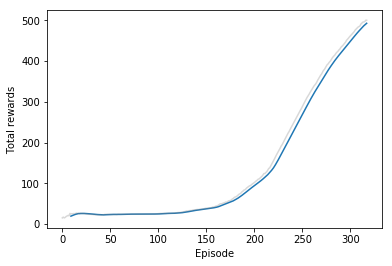

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

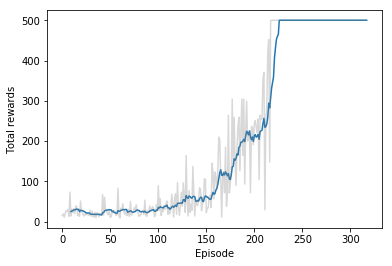

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

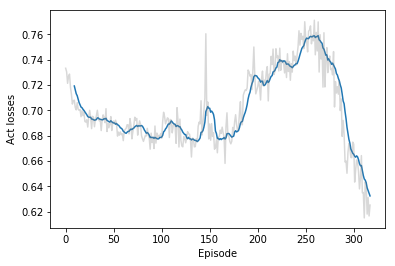

In [24]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

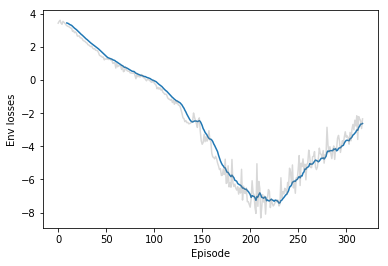

In [25]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

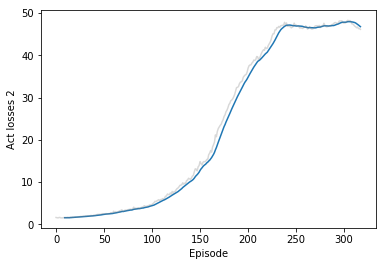

In [26]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
